In [ ]:
"""
Model Architecture + Baseline Loss
=============================================================

What you have:
- A clean model class that predicts 5 parameters: (cx, cy, l1, l2, l3).
- A simple baseline regression loss (SmoothL1 by default).

Expected I/O (very important):
- Input: 20×20 Grayscale image tensor, shape (N, 1, 20, 20).
- Output: tensor of shape (N, 5) = [cx, cy, l1, l2, l3].
- Target convention: l1 = Σ00, l2 = Σ11, l3 = Σ01 from the 2×2 covariance matrix.
- Normalization: **Targets for l1, l2, l3 should be divided by 400** before loss/training, so that all outputs are ~O(1).

Tasks:
1) Implement the Dataset + DataLoader to read images and JSON annotations.
2) Compute dataset mean/std and apply torchvision Normalize with those real stats.
3) Write the training/validation/test loops and metrics.
4) Implement Quantization-Aware Training (QAT): module fusion, observers, prepare_qat → train → convert.
5) Add evaluation plots and an ablation plan (baseline FP32 vs QAT variants).

Notes:
- This file intentionally omits logging, schedulers, early stopping, and custom constraints.
- You may widen/deepen the model, but keep the 5-output head.
"""

'\nModel Architecture + Baseline Loss\n=============================================================\n\nWhat you have:\n- A clean model class that predicts 5 parameters: (cx, cy, l1, l2, l3).\n- A simple baseline regression loss (SmoothL1 by default).\n\nExpected I/O (very important):\n- Input: 20×20 Grayscale image tensor, shape (N, 1, 20, 20).\n- Output: tensor of shape (N, 5) = [cx, cy, l1, l2, l3].\n- Target convention: l1 = Σ00, l2 = Σ11, l3 = Σ01 from the 2×2 covariance matrix.\n- Normalization: **Targets for l1, l2, l3 should be divided by 400** before loss/training, so that all outputs are ~O(1).\n\nTasks:\n1) Implement the Dataset + DataLoader to read images and JSON annotations.\n2) Compute dataset mean/std and apply torchvision Normalize with those real stats.\n3) Write the training/validation/test loops and metrics.\n4) Implement Quantization-Aware Training (QAT): module fusion, observers, prepare_qat → train → convert.\n5) Add evaluation plots and an ablation plan (baselin

In [1]:
from __future__ import annotations
import torch
import torch.nn as nn


In [2]:
import brevitas.nn as qnn
import brevitas.quant as quant
import torch.nn as nn

In [3]:
class EllipseRegressionModel(nn.Module):
    """Small CNN for regressing (cx, cy, l1, l2, l3) from 20×20 RGB.

    Design:
      - 4× (Conv → BN → LeakyReLU → MaxPool2d(2))
      - Flatten → 2× Linear → 5-dim output

    With 20×20 input, four 2× pools map features to 1×1.
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2)
        self.act = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, 5)  # (cx, cy, l1, l2, l3) — l* expected normalized by /400 in targets

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(self.act(self.bn1(self.conv1(x))))  # 20→10
        x = self.pool(self.act(self.bn2(self.conv2(x))))  # 10→5
        x = self.pool(self.act(self.bn3(self.conv3(x))))  # 5→2
        x = self.pool(self.act(self.bn4(self.conv4(x))))  # 2→1
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc_out(x)
        return out

In [4]:
class BaselineRegressionLoss(nn.Module):
    """Simple baseline loss for regression.

    - Uses SmoothL1 by default (robust, stable).
    - Assumes targets already normalized (l1,l2,l3 divided by 400 before batching).
    """

    def __init__(self, kind: str = "smoothl1"):
        super().__init__()
        if kind.lower() == "mse":
            self.crit = nn.MSELoss()
        else:
            self.crit = nn.SmoothL1Loss()

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.crit(preds, targets)

In [ ]:
# -----------------------------
# Minimal usage example (sketch)
# -----------------------------
# import torch.optim as optim
# model = EllipseRegressionModel().to(device)
# loss_fn = BaselineRegressionLoss(kind="smoothl1").to(device)
# opt = optim.Adam(model.parameters(), lr=1e-3)
# for imgs, targets in train_loader:  # student must implement DataLoader
#     imgs, targets = imgs.to(device), targets.to(device)
#     opt.zero_grad()
#     preds = model(imgs)
#     loss = loss_fn(preds, targets)
#     loss.backward()
#     opt.step()
#
# QAT:
# - Fuse (conv,bn,act) where applicable
# - Set qconfig (torch.ao.quantization.get_default_qat_qconfig)
# - prepare_qat(model) → train → convert(model) for inference

In [5]:

#  Dataset + Dataloader


from dataset import EllipseDataset       # make sure dataset.py is in the same folder as your notebook
from dataloader import create_dataloaders
from torchvision import transforms

#  Update these paths for your local setup
images_dir = "/home/hritik/Desktop/Hritik/Project/Dataset/Ellipses"
annotations_path = "/home/hritik/Desktop/Hritik/Project/Dataset/annotations.json"

#  Transform: Resize to 20×20 and convert to 1-channel (grayscale)
transform = transforms.Compose([
    transforms.Resize((20, 20)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

#  Create dataset and dataloaders
dataset = EllipseDataset(images_dir=images_dir, annotations_path=annotations_path, transform=transform)
train_loader, val_loader, test_loader = create_dataloaders(dataset, batch_size=64, num_workers=4)

print(f"Dataset loaded successfully with {len(dataset)} samples.")
print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")


Dataset loaded successfully with 1000000 samples.
Train: 800000, Val: 100000, Test: 100000


In [6]:
# Device selection (safe GPU/CPU auto-fallback)

import torch


def select_device(min_arch: int = 70) -> torch.device:
    """Return torch.device('cuda') if a usable CUDA GPU exists and meets the
    minimum compute capability (e.g. 70 -> sm_70). Otherwise return CPU.
    """
    if not torch.cuda.is_available():
        return torch.device('cpu')
    try:
        prop = torch.cuda.get_device_properties(0)
        compute = prop.major * 10 + prop.minor
        if compute >= min_arch:
            return torch.device('cuda')
        print(f"GPU {prop.name} compute capability {prop.major}.{prop.minor} < required {min_arch/10:.1f}; using CPU")
        return torch.device('cpu')
    except Exception:
        # fallback to CPU if querying properties fails
        return torch.device('cpu')


def move_batch_to_device(batch: dict, device: torch.device) -> dict:
    """Move all torch.Tensor values in batch (dict) to device; leave others unchanged."""
    return {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}


# Select device and print recommended pin_memory flag
device = select_device()
print('Selected device ->', device)
pin_memory = (device.type == 'cuda')
print('pin_memory recommended =', pin_memory)


# Safe smoke-check: move model and one batch to device, verify shapes before inference
# This check is defensive: it will not error if cells are run out-of-order.
if 'train_loader' not in globals():
    print('train_loader is not defined. Run the Dataset + Dataloader cell first. Skipping smoke-check.')
else:
    # Only attempt model forward if the model class is defined
    if 'EllipseRegressionModel' in globals():
        try:
            model = EllipseRegressionModel().to(device)
            model.eval()

            # Grab a batch from train_loader
            batch = next(iter(train_loader))

            # Inspect raw shapes before moving
            print('Raw batch shapes: image', batch['image'].shape, 'params', batch['params'].shape)

            # Move tensors in batch to device
            batch = move_batch_to_device(batch, device)
            images = batch['image']
            targets = batch['params']

            # Final device/shape checks
            print('Moved to device:', device)
            print('images device:', images.device, 'targets device:', targets.device)
            print('images shape:', images.shape, 'targets shape:', targets.shape)

            # Optional forward pass check
            with torch.no_grad():
                outputs = model(images)
            print('Forward OK — outputs shape:', outputs.shape)
        except Exception as e:
            import traceback
            print('Error during smoke-check:')
            traceback.print_exc()
    else:
        print('EllipseRegressionModel is not defined. Run the model-definition cell before this smoke-check.')


Selected device -> cuda
pin_memory recommended = True
Raw batch shapes: image torch.Size([64, 1, 20, 20]) params torch.Size([64, 5])
Moved to device: cuda
images device: cuda:0 targets device: cuda:0
images shape: torch.Size([64, 1, 20, 20]) targets shape: torch.Size([64, 5])
Forward OK — outputs shape: torch.Size([64, 5])


In [7]:
# Helper cell: compute ranges (min/max) for targets before normalization",
# It prefers `train_loader` (batches) if available, otherwise falls back to iterating `dataset`.
# Prints both the dataset-returned (normalized) ranges and denormalized ranges for l1,l2,l3 (×400).

import numpy as np
import torch

def _gather_all_targets():
    if 'train_loader' in globals():
        print('Collecting targets from train_loader (batched)...')
        parts = []
        for batch in train_loader:
            params = batch['params']
            if isinstance(params, torch.Tensor):
                parts.append(params.cpu().numpy())
            else:
                parts.append(np.asarray(params))
        return np.concatenate(parts, axis=0)
    elif 'dataset' in globals():
        print('Collecting targets by iterating dataset (may be slower)...')
        parts = []
        try:
            from tqdm import tqdm
            iterator = range(len(dataset))
            for i in tqdm(iterator, desc='reading dataset'):
                item = dataset[i]
                p = item['params']
                if isinstance(p, torch.Tensor):
                    parts.append(p.cpu().numpy())
                else:
                    parts.append(np.asarray(p))
        except Exception:
            # fallback without tqdm
            for i in range(len(dataset)):
                item = dataset[i]
                p = item['params']
                if isinstance(p, torch.Tensor):
                    parts.append(p.cpu().numpy())
                else:
                    parts.append(np.asarray(p))
        return np.stack(parts, axis=0)
    else:
        raise RuntimeError('Neither `train_loader` nor `dataset` found in globals. Run the Dataset + Dataloader cell first.')

try:
    all_params = _gather_all_targets()
    assert all_params.ndim == 2 and all_params.shape[1] == 5, f'unexpected params shape: {all_params.shape}'

    names = ['cx', 'cy', 'lxx', 'lxy', 'lyy']

    mins = all_params.min(axis=0)
    maxs = all_params.max(axis=0)
    means = all_params.mean(axis=0)
    stds = all_params.std(axis=0)

    print('\nNormalized ranges:')
    for i, name in enumerate(names):
        print(f'  {name:>3}: min={mins[i]:.6g}, max={maxs[i]:.6g}, mean={means[i]:.6g}, std={stds[i]:.6g}')

    # Denormalize l1,l2,l3 by multiplying by 400 (common convention used in this project)
    denorm = all_params.copy()
    denorm[:, 2:5] = denorm[:, 2:5] * 400.0
    mins_d = denorm.min(axis=0)
    maxs_d = denorm.max(axis=0)
    means_d = denorm.mean(axis=0)
    stds_d = denorm.std(axis=0)

    print('\nDenormalized ranges (lxx,lxy,lyy multiplied by 400):')
    for i, name in enumerate(names):
        print(f'  {name:>3}: min={mins_d[i]:.6g}, max={maxs_d[i]:.6g}, mean={means_d[i]:.6g}, std={stds_d[i]:.6g}')

except Exception as e:
    print('Failed to compute target ranges:', e)
    raise


Normalized ranges:
   cx: min=5.33106, max=34.6247, mean=20.0063, std=4.61706
   cy: min=5.36937, max=34.7364, mean=20.0014, std=4.60874
  lxx: min=25.0346, max=393.264, mean=136.24, std=59.6062
  lxy: min=25.0031, max=395.514, mean=136.345, std=59.5843
  lyy: min=-185.593, max=185.856, mean=-0.079937, std=46.0182

Denormalized ranges (lxx,lxy,lyy multiplied by 400):
   cx: min=5.33106, max=34.6247, mean=20.0063, std=4.61706
   cy: min=5.36937, max=34.7364, mean=20.0014, std=4.60874
  lxx: min=10013.8, max=157305, mean=54495.8, std=23842.2
  lxy: min=10001.3, max=158205, mean=54537, std=23833.7
  lyy: min=-74237.2, max=74342.5, mean=-31.974, std=18407.8


Image ID: 487752
cx=20.51, cy=18.60
lxx=248.786, lxy=290.144, lyy=86.150
Derived: a=21.652, b=nan, θ=-142.83°



/tmp/ipykernel_4805/2873859933.py:25: RuntimeWarning: invalid value encountered in sqrt
  a, b = np.sqrt(eigenvalues)


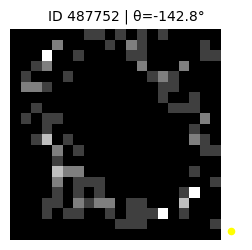

Image ID: 692777
cx=11.88, cy=19.13
lxx=56.527, lxy=119.231, lyy=32.596
Derived: a=12.822, b=nan, θ=-137.87°



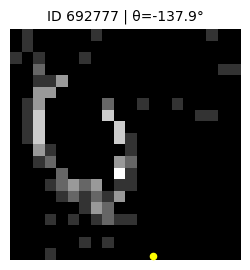

Image ID: 905634
cx=18.29, cy=15.35
lxx=112.990, lxy=161.061, lyy=-17.635
Derived: a=14.882, b=nan, θ=-146.04°



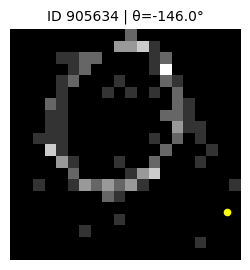

Image ID: 543621
cx=20.95, cy=14.94
lxx=222.905, lxy=161.509, lyy=-90.594
Derived: a=17.065, b=nan, θ=-157.07°



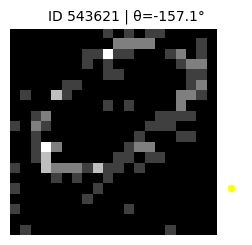

Image ID: 598
cx=18.72, cy=18.12
lxx=123.564, lxy=156.075, lyy=31.329
Derived: a=15.498, b=nan, θ=-143.23°



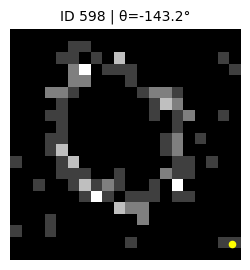

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

#  Function to compute a,b,theta from covariance matrix 
def ellipse_from_covariance(l1, l2, l3):
    """
    Given covariance matrix elements (l1=lxx, l2=lxy, l3=lyy),
    return (a, b, theta):
    - a: semi-major axis length
    - b: semi-minor axis length
    - theta: orientation angle in degrees
    """
    cov = np.array([[l1, l2],
                    [l2, l3]])

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # Sort eigenvalues descending
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    a, b = np.sqrt(eigenvalues)
    theta = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    return a, b, theta


#  Visualize few random samples 
num_samples = 5  # how many ellipses to visualize
indices = random.sample(range(len(dataset)), num_samples)

for idx in indices:
    sample = dataset[idx]
    img = sample["image"].permute(1, 2, 0).numpy()
    params = sample["params"].numpy()
    cx, cy = params[0], params[1]
    l1, l2, l3 = params[2], params[3], params[4]

    a, b, theta = ellipse_from_covariance(l1, l2, l3)

    print(f"Image ID: {sample['image_id']}")
    print(f"cx={cx:.2f}, cy={cy:.2f}")
    print(f"lxx={l1:.3f}, lxy={l2:.3f}, lyy={l3:.3f}")
    print(f"Derived: a={a:.3f}, b={b:.3f}, θ={theta:.2f}°\n")

    # Plot image + ellipse outline 
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img, cmap="gray")
    ax.set_title(f"ID {sample['image_id']} | θ={theta:.1f}°", fontsize=10)

    # Create the ellipse outline using derived values
    ellipse = patches.Ellipse(
        (cx, cy), width=2*a, height=2*b, angle=theta,
        edgecolor="red", facecolor="none", linewidth=2
    )
    ax.add_patch(ellipse)
    ax.scatter(cx, cy, color="yellow", s=20)  # mark center
    ax.set_axis_off()
    plt.show()


In [9]:

#  Baseline Inference  (GPU if available, else CPU)

import torch
import sys

# Determine device: prefer an existing `device` or `select_device()` helper if present,
# otherwise choose CUDA if available else CPU. This prints informative messages.
_device = globals().get('device', None)
if _device is not None:
    device = _device
else:
    sel = globals().get('select_device', None)
    if callable(sel):
        try:
            device = sel()
        except Exception as e:
            print('select_device() failed, falling back to torch defaults:', e)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        # No helper: prefer CUDA if available. Print device properties when possible.
        if torch.cuda.is_available():
            try:
                prop = torch.cuda.get_device_properties(0)
                print(f'CUDA available: {prop.name} compute {prop.major}.{prop.minor}')
            except Exception as e:
                print('Could not query CUDA device properties:', e)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

print(f'Using device: {device}')

# Initialize model and move to the selected device
model = EllipseRegressionModel().to(device)
model.eval()

# Load a small batch and move it to the selected device
batch = next(iter(train_loader))
batch = move_batch_to_device(batch, device)
images = batch['image']
targets = batch['params']

# Run inference
with torch.no_grad():
    outputs = model(images)

print(' Inference ran successfully!')
print('Predictions shape:', outputs.shape)
print('Sample prediction:', outputs[0])
print('Sample target:', targets[0])


Using device: cuda
 Inference ran successfully!
Predictions shape: torch.Size([64, 5])
Sample prediction: tensor([-0.0048,  0.0372,  0.0336,  0.0310,  0.0405], device='cuda:0')
Sample target: tensor([ 19.3368,  22.2159, 249.3609, 253.5711,   9.5992], device='cuda:0')


Evaluation will run on device: cuda
MAE per output (cx,cy,lxx,lxy,lyy): [19.95743751525879, 20.063804626464844, 136.32858276367188, 136.41416931152344, 34.103023529052734]
RMSE per output (cx,cy,lxx,lxy,lyy): [20.485157012939453, 20.584266662597656, 148.83131408691406, 148.9708709716797, 46.1888542175293]
Mean MAE: 69.37339782714844 Mean RMSE: 77.01210021972656
Denorm MAE (lxx,lxy,lyy) [units]: [54531.44140625, 54565.671875, 13641.2099609375]
Denorm RMSE (lxx,lxy,lyy) [units]: [59532.5234375, 59588.34765625, 18475.54296875]

First 5 examples (pred -> target):
[0] pred: [ 0.02115844 -0.03844006 -0.02166765 -0.0313632   0.00014673]  target: [ 22.414246  25.482195 230.19955  105.66702  -50.447006]
[1] pred: [ 2.0761197e-02 -3.8796421e-02 -2.1667670e-02 -3.1244917e-02
  4.3692999e-05]  target: [ 26.029846  19.571836 148.69678  235.97034   77.93222 ]
[2] pred: [ 0.02121131 -0.03799616 -0.02129806 -0.03235942  0.00075589]  target: [ 8.202352 14.203071 48.678593 96.13924  17.51433 ]
[3] pred:

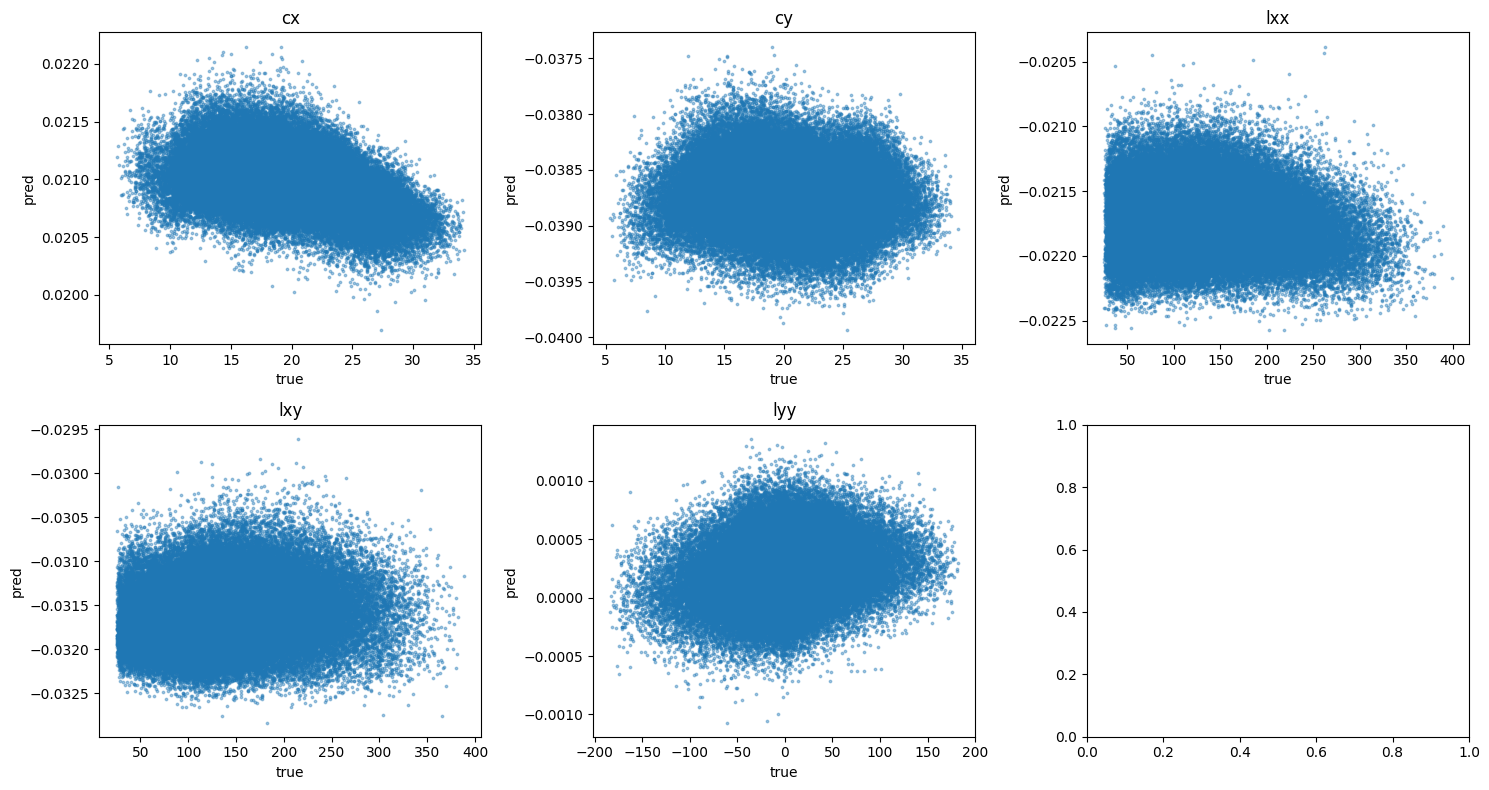

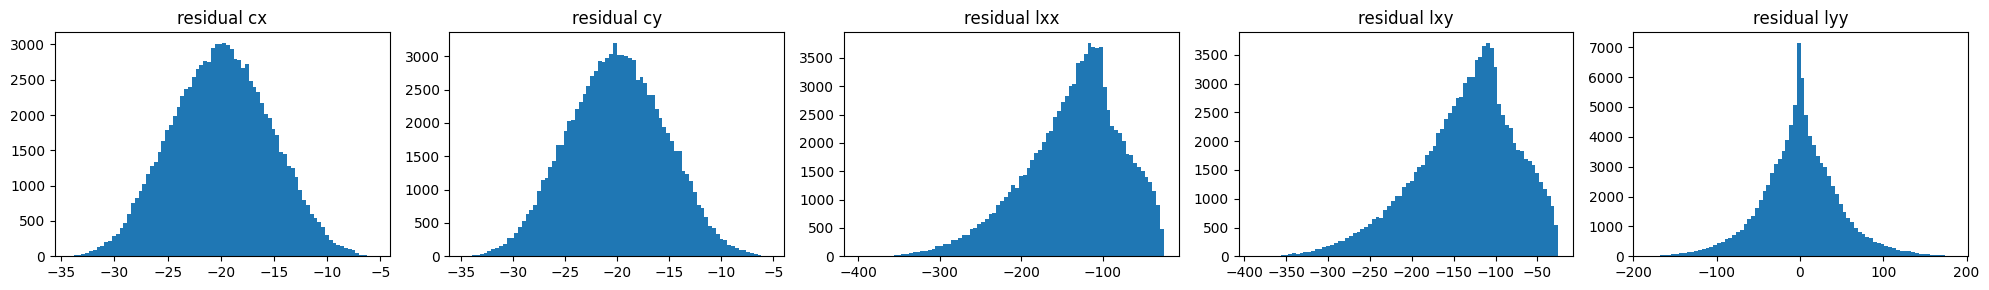

Evaluation complete.


In [10]:
# Evaluation: MAE / RMSE + diagnostic plots
# Runs the model over `val_loader` and prints per-output and overall metrics.
import torch
import numpy as np

# Determine device (prefer existing `device` or fall back)
device = globals().get('device') if globals().get('device', None) is not None else (select_device() if globals().get('select_device', None) else (torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
print('Evaluation will run on device:', device)

model = EllipseRegressionModel().to(device)
model.eval()

# Collect predictions and targets (keep on CPU to reduce GPU memory)
preds_list = []
tgt_list = []
with torch.no_grad():
    for batch in val_loader:
        batch = move_batch_to_device(batch, device)
        out = model(batch['image'])
        preds_list.append(out.cpu())
        tgt_list.append(batch['params'].cpu())

preds = torch.cat(preds_list, dim=0)
tgt = torch.cat(tgt_list, dim=0)

# Per-output metrics
diff = preds - tgt
mae_per = torch.mean(diff.abs(), dim=0)
rmse_per = torch.sqrt(torch.mean(diff**2, dim=0))
print('MAE per output (cx,cy,lxx,lxy,lyy):', mae_per.tolist())
print('RMSE per output (cx,cy,lxx,lxy,lyy):', rmse_per.tolist())
print('Mean MAE:', float(mae_per.mean()), 'Mean RMSE:', float(rmse_per.mean()))

# If l1/l2/l3 were normalized by 400 in the dataset, show denormalized metrics for those outputs
try:
    # assume normalization used: l1,l2,l3 divided by 400
    denorm_preds = preds.clone()
    denorm_tgt = tgt.clone()
    denorm_preds[:,2:5] *= 400.0
    denorm_tgt[:,2:5] *= 400.0
    denorm_diff = denorm_preds - denorm_tgt
    denorm_mae = torch.mean(denorm_diff.abs(), dim=0)
    denorm_rmse = torch.sqrt(torch.mean(denorm_diff**2, dim=0))
    print('Denorm MAE (lxx,lxy,lyy) [units]:', denorm_mae[2:5].tolist())
    print('Denorm RMSE (lxx,lxy,lyy) [units]:', denorm_rmse[2:5].tolist())
except Exception:
    pass

# Print a small table of samples: true vs pred for first 5 examples
n_show = min(5, preds.shape[0])
print(f'\nFirst {n_show} examples (pred -> target):')
for i in range(n_show):
    print(f'[{i}] pred:', preds[i].numpy(), ' target:', tgt[i].numpy())

# Diagnostic plots (scatter + residual histograms) if matplotlib is available
try:
    import matplotlib.pyplot as plt
    import math
    preds_np = preds.numpy()
    tgt_np = tgt.numpy()
    # Scatter for cx and cx residuals
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()
    labels = ['cx', 'cy', 'lxx', 'lxy', 'lyy']
    for j in range(5):
        axes[j].scatter(tgt_np[:, j], preds_np[:, j], s=3, alpha=0.4)
        axes[j].set_title(labels[j])
        axes[j].set_xlabel('true')
        axes[j].set_ylabel('pred')
    plt.tight_layout()
    plt.show()
    # Residual histograms for each output (include cx and cy as well)
    fig2, axes2 = plt.subplots(1, 5, figsize=(20, 3))
    for k in range(5):
        axes2[k].hist((preds_np[:, k]-tgt_np[:, k]), bins=80)
        axes2[k].set_title(f'residual {labels[k]}')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Matplotlib unavailable or plotting failed:', e)

print('Evaluation complete.')


In [36]:

#  FP32 TRAINING LOOP 

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Step: Device selection (safe fallback)
GPU_MIN_ARCH = globals().get('GPU_MIN_ARCH', 70)
try:
    device = select_device(min_arch=GPU_MIN_ARCH)
except Exception as e:
    print('select_device() unavailable or failed, using torch default:', e)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

globals()['device'] = device
print("Using device:", device)

# Step: Model and Loss
model = EllipseRegressionModel().to(device)

# Use SmoothL1Loss if available, else fallback to MSELoss
try:
    loss_fn = nn.SmoothL1Loss()
    loss_name = "SmoothL1Loss"
except AttributeError:
    loss_fn = nn.MSELoss()
    loss_name = "MSELoss"

loss_fn = loss_fn.to(device)
print("Using loss:", loss_name)

# Step: Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Reduce learning rate when validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
if hasattr(scheduler, 'verbose'):
    scheduler.verbose = True  # only works on newer PyTorch versions

# Step: Training parameters
num_epochs = 150
best_val_loss = float('inf')
best_epoch = 0

print("\n Starting FP32 training...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    #  Training Loop 
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = batch['image'].to(device)
        targets = batch['params'].to(device)

        # Normalize covariance matrix terms (l1, l2, l3)
        targets_norm = targets.clone()
        targets_norm[:, 2:] /= 400.0

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, targets_norm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    #  Validation Loop
    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            targets = batch['params'].to(device)

            tgt_norm = targets.clone()
            tgt_norm[:, 2:] /= 400.0

            preds = model(images)
            vloss = loss_fn(preds, tgt_norm)
            val_loss_total += vloss.item() * images.size(0)

    avg_val_loss = val_loss_total / len(val_loader.dataset)

    # Scheduler update (adjust learning rate)
    scheduler.step(avg_val_loss)
    print(f"→ Scheduler adjusted LR: {optimizer.param_groups[0]['lr']:.2e}")

    #  Epoch Summary 
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Save best model 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "ellipse_fp32_best.pth")
        print(f" Saved best model at epoch {best_epoch} (val loss {best_val_loss:.6f})")

print(f"\n Training complete! Best val loss {best_val_loss:.6f} at epoch {best_epoch}.")


GPU NVIDIA GeForce MX330 compute capability 6.1 < required 7.0; using CPU
Using device: cpu
Using loss: SmoothL1Loss

 Starting FP32 training...



Epoch 1/150:   1%|          | 116/12500 [00:06<11:00, 18.76it/s]


KeyboardInterrupt: 

In [12]:

# Cell: Save FP32 Trained Model


# Save final model (last epoch)
torch.save(model.state_dict(), "ellipse_fp32_final.pth")
print("FP32 model (final epoch) saved as 'ellipse_fp32_final.pth'")



FP32 model (final epoch) saved as 'ellipse_fp32_final.pth'


In [12]:
#  Cell: Load FP32 Model for Inference (with target normalization)

import torch

# Define the model architecture (must match training)
model = EllipseRegressionModel()

# Load saved weights
checkpoint_path = "ellipse_fp32_best.pth"  # or "ellipse_fp32_final.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # device = 'cpu' or 'cuda'

# Move model to the selected device and set to eval
model = model.to(device)
model.eval()

print(f"FP32 model loaded from '{checkpoint_path}' and ready for inference on device {device}.")

# Quick inference test on one batch 
batch = next(iter(test_loader))  # use your test DataLoader

images = batch["image"].to(device)
targets = batch["params"].to(device)

# 🔹 Normalize l1, l2, l3 of the targets (same scaling used during training)
targets[:, 2:] = targets[:, 2:] / 400.0

# Run inference
with torch.no_grad():
    preds = model(images)

# Display results 
print("Predictions shape:", preds.shape)
print("\nFirst 5 predictions (normalized):")
print(preds[:5])

print("\nFirst 5 targets (normalized):")
print(targets[:5])

# Optional: Mean absolute difference just for a quick sanity check
mae = torch.mean(torch.abs(preds - targets), dim=0)
print("\nQuick MAE per parameter (cx, cy, lxx, lxy, lyy):", mae.cpu().numpy())


FP32 model loaded from 'ellipse_fp32_best.pth' and ready for inference on device cuda.
Predictions shape: torch.Size([64, 5])

First 5 predictions (normalized):
tensor([[ 2.0439e+01,  1.8988e+01,  1.8273e-01,  5.8989e-01,  9.7251e-04],
        [ 2.0442e+01,  1.9985e+01,  3.1480e-01,  6.9340e-01, -9.1916e-02],
        [ 2.1846e+01,  1.9610e+01,  3.1883e-01,  3.2659e-01, -3.0410e-02],
        [ 1.7239e+01,  1.8540e+01,  3.5157e-01,  2.1738e-01, -7.9306e-03],
        [ 2.1696e+01,  1.2283e+01,  2.5970e-01,  2.0162e-01,  6.5148e-02]],
       device='cuda:0')

First 5 targets (normalized):
tensor([[ 2.0530e+01,  1.9027e+01,  1.7677e-01,  6.2602e-01,  1.0647e-02],
        [ 2.0386e+01,  1.9838e+01,  3.0889e-01,  6.7417e-01, -9.6849e-02],
        [ 2.1411e+01,  1.9429e+01,  3.1291e-01,  3.1779e-01, -3.0077e-02],
        [ 1.7494e+01,  1.7933e+01,  3.7032e-01,  2.0835e-01, -5.2507e-03],
        [ 2.1951e+01,  1.2179e+01,  2.5417e-01,  1.9262e-01,  7.1709e-02]],
       device='cuda:0')

Quick M

Evaluating FP32 model: 100%|██████████| 1563/1563 [00:06<00:00, 248.51it/s]


Median magnitudes (pred l1,l2,l3): [0.31555918 0.32927287 0.06291346]
Median magnitudes (tgt  l1,l2,l3): [128.18086  128.19984   25.630848]
-> predictions l looks normalized (median 0.249); applying *400.0 denorm factor.
-> targets l looks already denormalized (median 98.988); leaving as-is.
Median cx pred=20.038, tgt=20.000

MAE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.17122865 0.17272805 6.1069126  6.525936   4.9569693 ]
RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.22208476 0.22320415 7.986461   8.3751335  6.43963   ]
Mean MAE: 3.586755, Mean RMSE: 4.649303



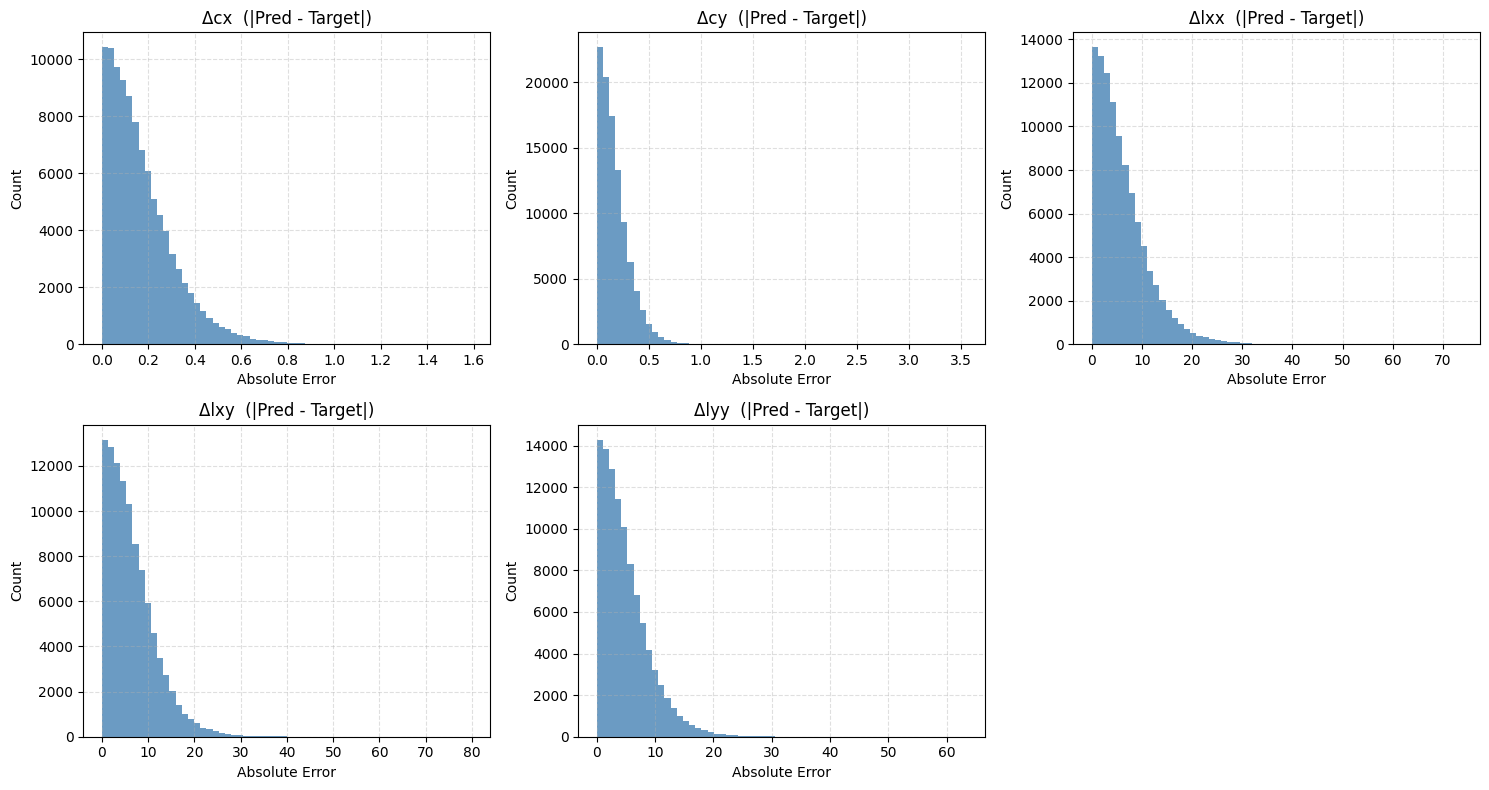

Δcx: mean Δ=0.171, std=0.141, max Δ=1.591
Δcy: mean Δ=0.173, std=0.141, max Δ=3.552
Δlxx: mean Δ=6.107, std=5.147, max Δ=73.695
Δlxy: mean Δ=6.526, std=5.249, max Δ=79.868
Δlyy: mean Δ=4.957, std=4.111, max Δ=63.407


In [13]:

# Cell: Evaluate FP32 Model + Δ (Delta) Histograms


import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

DENORM = 400.0  # the factor used during training: targets[:,2:] /= DENORM

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets (raw from model and dataset)
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating FP32 model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)   # dataset-provided values (likely raw)
        preds = model(images)                  # model outputs (likely normalized for l1,l2,l3)

        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Diagnostics: inspect typical magnitudes for covariance components
pred_l_med = np.median(np.abs(all_preds[:, 2:]), axis=0)
tgt_l_med = np.median(np.abs(all_targets[:, 2:]), axis=0)
print("Median magnitudes (pred l1,l2,l3):", pred_l_med)
print("Median magnitudes (tgt  l1,l2,l3):", tgt_l_med)

# Heuristic to decide if values are normalized (≈O(1)) or already denormalized (>>1)
def maybe_denorm(arr, name):
    """If arr's median magnitude is small (<=5), assume it's normalized and denorm it."""
    med = np.median(np.abs(arr))
    if med <= 5.0:
        print(f"-> {name} looks normalized (median {med:.3f}); applying *{DENORM} denorm factor.")
        return arr * DENORM, True
    else:
        print(f"-> {name} looks already denormalized (median {med:.3f}); leaving as-is.")
        return arr, False

# Apply detection & denormalization for covariance parts separately for preds & targets
# Work on copies to avoid accidental double multiplication
preds_work = all_preds.copy()
targs_work = all_targets.copy()

# Denormalize l1,l2,l3 if needed
preds_work[:, 2:], pred_denormed = maybe_denorm(preds_work[:, 2:], "predictions l")
targs_work[:, 2:], targ_denormed = maybe_denorm(targs_work[:, 2:], "targets l")

# (Optional) If cx/cy appear normalized (very small), print a warning; we don't auto-scale cx/cy
cx_med_pred = np.median(np.abs(preds_work[:,0]))
cx_med_targ = np.median(np.abs(targs_work[:,0]))
print(f"Median cx pred={cx_med_pred:.3f}, tgt={cx_med_targ:.3f}")
if np.median(np.abs(preds_work[:, :2])) <= 5.0 and np.median(np.abs(all_targets[:, :2])) > 5.0:
    print("Note: predictions cx/cy look small while targets are large — check coordinate frames.")
# We avoid guessing for cx/cy scaling automatically to prevent incorrect rescaling.

# Now compute absolute differences (denormalized)
delta = np.abs(preds_work - targs_work)

# Compute MAE and RMSE based on the (now) denormalized arrays
mae_per_output = np.mean(delta, axis=0)
rmse_per_output = np.sqrt(np.mean((preds_work - targs_work) ** 2, axis=0))
mean_mae = np.mean(mae_per_output)
mean_rmse = np.mean(rmse_per_output)

print("\nMAE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", mae_per_output)
print("RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", rmse_per_output)
print(f"Mean MAE: {mean_mae:.6f}, Mean RMSE: {mean_rmse:.6f}\n")

# Plot histograms of absolute errors (Δ)
output_names = ["Δcx", "Δcy", "Δlxx", "Δlxy", "Δlyy"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, name in enumerate(output_names):
    axes[i].hist(delta[:, i], bins=60, color="steelblue", alpha=0.8)
    axes[i].set_title(f"{name}  (|Pred - Target|)")
    axes[i].set_xlabel("Absolute Error")
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle="--", alpha=0.4)

# Hide extra subplot
if len(output_names) < len(axes):
    for j in range(len(output_names), len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()

# Print summary stats
for i, name in enumerate(output_names):
    print(f"{name}: mean Δ={delta[:, i].mean():.3f}, std={delta[:, i].std():.3f}, max Δ={delta[:, i].max():.3f}")


In [14]:

# Cell: Evaluate FP32 Model — MAE, RMSE, r, R²


import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = model(images)
        
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate and convert to numpy
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance terms (l1, l2, l3)
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

# Compute metrics
mae = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(all_targets, all_preds, multioutput='raw_values'))
r2 = r2_score(all_targets, all_preds, multioutput='raw_values')

pearson_r = []
for i in range(all_preds.shape[1]):
    r, _ = pearsonr(all_targets[:, i], all_preds[:, i])
    pearson_r.append(r)
pearson_r = np.array(pearson_r)

# Pretty report
output_names = ["cx", "cy", "lxx", "lxy", "lyy"]

print("\nMODEL PERFORMANCE METRICS \n")
for i, name in enumerate(output_names):
    print(f"{name}:")
    print(f"  MAE   = {mae[i]:.4f}")
    print(f"  RMSE  = {rmse[i]:.4f}")
    print(f"  r     = {pearson_r[i]:.4f}")
    print(f"  R²    = {r2[i]:.4f}")
    #print("-" * 35)

print(f"\nMean MAE  : {mae.mean():.4f}")
print(f"Mean RMSE : {rmse.mean():.4f}")
print(f"Mean r    : {pearson_r.mean():.4f}")
print(f"Mean R²   : {r2.mean():.4f}")


Evaluating model: 100%|██████████| 1563/1563 [00:02<00:00, 548.30it/s]



MODEL PERFORMANCE METRICS 

cx:
  MAE   = 0.1712
  RMSE  = 0.2221
  r     = 0.9989
  R²    = 0.9977
cy:
  MAE   = 0.1727
  RMSE  = 0.2232
  r     = 0.9988
  R²    = 0.9977
lxx:
  MAE   = 6.1069
  RMSE  = 7.9865
  r     = 0.9915
  R²    = 0.9821
lxy:
  MAE   = 6.5259
  RMSE  = 8.3751
  r     = 0.9915
  R²    = 0.9802
lyy:
  MAE   = 4.9570
  RMSE  = 6.4396
  r     = 0.9905
  R²    = 0.9803

Mean MAE  : 3.5868
Mean RMSE : 4.6493
Mean r    : 0.9943
Mean R²   : 0.9876


In [15]:

# Evaluate Model — Relative Error (%)


import numpy as np
import torch
from tqdm import tqdm

model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting predictions"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = model(images)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance components (l1, l2, l3)
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

# Compute absolute errors
abs_error = np.abs(all_preds - all_targets)

# Compute relative errors (%)
rel_error = abs_error / (np.abs(all_targets) + 1e-8) * 100  # add small epsilon to avoid division by zero

# Summary stats
output_names = ["cx", "cy", "lxx", "lxy", "lyy"]
for i, name in enumerate(output_names):
    mean_rel = np.mean(rel_error[:, i])
    max_rel = np.max(rel_error[:, i])
    print(f"{name}: mean relative error = {mean_rel:.2f}%") #, max relative error = {max_rel:.2f}%")


cx: mean relative error = 0.91%
cy: mean relative error = 0.92%
lxx: mean relative error = 5.18%
lxy: mean relative error = 5.80%
lyy: mean relative error = 1459.26%


In [16]:

# Initialize from FP32 weights (for QAT)


import torch
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU

# Load FP32 weights
fp32_checkpoint = "ellipse_fp32_best.pth"
fp32_model = EllipseRegressionModel()
fp32_model.load_state_dict(torch.load(fp32_checkpoint, map_location='cpu'))
fp32_model.eval()

print(f"Loaded FP32 weights from '{fp32_checkpoint}'")


Loaded FP32 weights from 'ellipse_fp32_best.pth'


In [7]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFloat
import torch.nn as nn

class QuantizedEllipseRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = QuantConv2d(1, 32, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = QuantConv2d(32, 64, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = QuantConv2d(64, 128, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = QuantConv2d(128, 256, kernel_size=3, padding=1,
                                 weight_bit_width=8, bias=False,
                                 weight_quant=Int8WeightPerTensorFloat)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2)
        self.act = QuantReLU(bit_width=8)
        
        self.fc1 = QuantLinear(256*1*1, 512, weight_bit_width=8, bias=False)
        self.fc2 = QuantLinear(512, 256, weight_bit_width=8, bias=False)
        self.fc_out = QuantLinear(256, 5, weight_bit_width=8, bias=False)

    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = self.pool(self.act(self.bn3(self.conv3(x))))
        x = self.pool(self.act(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.fc_out(x)


In [8]:

#  Initialize Quantized Model from FP32 Weights


import torch

# Load your trained FP32 model weights (make sure path is correct)
fp32_model_path = "ellipse_fp32_best.pth"
fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load(fp32_model_path, map_location=device))
fp32_model.eval()

# Initialize quantized model
q_model = QuantizedEllipseRegressionModel().to(device)

# Copy FP32 weights layer by layer
with torch.no_grad():
    # Conv layers
    q_model.conv1.weight.copy_(fp32_model.conv1.weight)
    q_model.conv2.weight.copy_(fp32_model.conv2.weight)
    q_model.conv3.weight.copy_(fp32_model.conv3.weight)
    q_model.conv4.weight.copy_(fp32_model.conv4.weight)

    # BatchNorm layers
    q_model.bn1.load_state_dict(fp32_model.bn1.state_dict())
    q_model.bn2.load_state_dict(fp32_model.bn2.state_dict())
    q_model.bn3.load_state_dict(fp32_model.bn3.state_dict())
    q_model.bn4.load_state_dict(fp32_model.bn4.state_dict())

    # Fully connected layers
    q_model.fc1.weight.copy_(fp32_model.fc1.weight)
    q_model.fc2.weight.copy_(fp32_model.fc2.weight)
    q_model.fc_out.weight.copy_(fp32_model.fc_out.weight)

print("Quantized model initialized with FP32 pretrained weights.")


Quantized model initialized with FP32 pretrained weights.


In [ ]:
# Quantization-Aware Training (QAT)


import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# QAT Setup 
num_epochs_qat = 30  # fewer epochs than FP32 training (since weights are initialized)
learning_rate_qat = 1e-4

# Define loss and optimizer
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(q_model.parameters(), lr=learning_rate_qat, weight_decay=1e-5)

# Optional: learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

best_val_loss = float('inf')

print("Starting Quantization-Aware Training...")

for epoch in range(num_epochs_qat):
    q_model.train()
    running_loss = 0.0

    # --- Training loop ---
    for batch in tqdm(train_loader, desc=f"QAT Epoch {epoch+1}/{num_epochs_qat}"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        targets_norm = targets.clone()
        targets_norm[:, 2:] = targets_norm[:, 2:] / 400.0  # normalize l1,l2,l3

        optimizer.zero_grad()
        preds = q_model(images)
        loss = criterion(preds, targets_norm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # --- Validation ---
    q_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            targets = batch["params"].to(device)
            tgt_norm = targets.clone()
            tgt_norm[:, 2:] = tgt_norm[:, 2:] / 400.0
            preds = q_model(images)
            loss = criterion(preds, tgt_norm)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs_qat}]  Train Loss: {avg_train_loss:.6f}  |  Val Loss: {avg_val_loss:.6f}")

    # --- Save best model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(q_model.state_dict(), "ellipse_qat_best.pth")
        print(f"Saved best QAT model (val loss = {best_val_loss:.6f})")

print("QAT training complete!")

Starting Quantization-Aware Training...


QAT Epoch 1/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.66it/s]


Epoch [1/30]  Train Loss: 0.010244  |  Val Loss: 0.009688
Saved best QAT model (val loss = 0.009688)


QAT Epoch 2/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.68it/s]


Epoch [2/30]  Train Loss: 0.010087  |  Val Loss: 0.010464


QAT Epoch 3/30: 100%|██████████| 12500/12500 [01:52<00:00, 111.13it/s]


Epoch [3/30]  Train Loss: 0.009993  |  Val Loss: 0.012548


QAT Epoch 4/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.70it/s]


Epoch [4/30]  Train Loss: 0.009934  |  Val Loss: 0.010239


QAT Epoch 5/30: 100%|██████████| 12500/12500 [01:46<00:00, 117.07it/s]


Epoch [5/30]  Train Loss: 0.009858  |  Val Loss: 0.010280


QAT Epoch 6/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.17it/s]


Epoch [6/30]  Train Loss: 0.009800  |  Val Loss: 0.012147


QAT Epoch 7/30: 100%|██████████| 12500/12500 [01:45<00:00, 118.61it/s]


Epoch [7/30]  Train Loss: 0.009769  |  Val Loss: 0.010337


QAT Epoch 8/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.63it/s]


Epoch [8/30]  Train Loss: 0.008856  |  Val Loss: 0.009566
Saved best QAT model (val loss = 0.009566)


QAT Epoch 9/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.02it/s]


Epoch [9/30]  Train Loss: 0.008810  |  Val Loss: 0.009169
Saved best QAT model (val loss = 0.009169)


QAT Epoch 10/30: 100%|██████████| 12500/12500 [01:45<00:00, 118.34it/s]


Epoch [10/30]  Train Loss: 0.008779  |  Val Loss: 0.009299


QAT Epoch 11/30: 100%|██████████| 12500/12500 [01:46<00:00, 116.84it/s]


Epoch [11/30]  Train Loss: 0.008743  |  Val Loss: 0.009428


QAT Epoch 12/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.25it/s]


Epoch [12/30]  Train Loss: 0.008725  |  Val Loss: 0.008985
Saved best QAT model (val loss = 0.008985)


QAT Epoch 13/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.73it/s]


Epoch [13/30]  Train Loss: 0.008708  |  Val Loss: 0.009026


QAT Epoch 14/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.71it/s]


Epoch [14/30]  Train Loss: 0.008673  |  Val Loss: 0.009767


QAT Epoch 15/30: 100%|██████████| 12500/12500 [01:48<00:00, 114.88it/s]


Epoch [15/30]  Train Loss: 0.008684  |  Val Loss: 0.009118


QAT Epoch 16/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.75it/s]


Epoch [16/30]  Train Loss: 0.008661  |  Val Loss: 0.009186


QAT Epoch 17/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.37it/s]


Epoch [17/30]  Train Loss: 0.008637  |  Val Loss: 0.009289


QAT Epoch 18/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.66it/s]


Epoch [18/30]  Train Loss: 0.008635  |  Val Loss: 0.009754


QAT Epoch 19/30: 100%|██████████| 12500/12500 [01:48<00:00, 114.76it/s]


Epoch [19/30]  Train Loss: 0.008123  |  Val Loss: 0.009060


QAT Epoch 20/30: 100%|██████████| 12500/12500 [01:45<00:00, 117.95it/s]


Epoch [20/30]  Train Loss: 0.008092  |  Val Loss: 0.009645


QAT Epoch 21/30: 100%|██████████| 12500/12500 [01:47<00:00, 115.76it/s]


Epoch [21/30]  Train Loss: 0.008072  |  Val Loss: 0.009160


QAT Epoch 22/30: 100%|██████████| 12500/12500 [01:47<00:00, 115.79it/s]


Epoch [22/30]  Train Loss: 0.008055  |  Val Loss: 0.009225


QAT Epoch 23/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.63it/s]


Epoch [23/30]  Train Loss: 0.008048  |  Val Loss: 0.008933
Saved best QAT model (val loss = 0.008933)


QAT Epoch 24/30: 100%|██████████| 12500/12500 [01:47<00:00, 116.07it/s]


Epoch [24/30]  Train Loss: 0.008030  |  Val Loss: 0.009169


QAT Epoch 25/30: 100%|██████████| 12500/12500 [01:46<00:00, 117.23it/s]


Epoch [25/30]  Train Loss: 0.008025  |  Val Loss: 0.009478


QAT Epoch 26/30: 100%|██████████| 12500/12500 [01:49<00:00, 114.43it/s]


Epoch [26/30]  Train Loss: 0.008016  |  Val Loss: 0.009066


QAT Epoch 27/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.70it/s]


Epoch [27/30]  Train Loss: 0.008004  |  Val Loss: 0.008859
Saved best QAT model (val loss = 0.008859)


QAT Epoch 28/30: 100%|██████████| 12500/12500 [01:46<00:00, 116.95it/s]


Epoch [28/30]  Train Loss: 0.007988  |  Val Loss: 0.008990


QAT Epoch 29/30: 100%|██████████| 12500/12500 [01:48<00:00, 115.42it/s]


Epoch [29/30]  Train Loss: 0.007975  |  Val Loss: 0.009081


QAT Epoch 30/30: 100%|██████████| 12500/12500 [01:50<00:00, 112.99it/s]


Epoch [30/30]  Train Loss: 0.007960  |  Val Loss: 0.008909
QAT training complete!


In [28]:

# Evaluate QAT Model — MAE, RMSE, r, R²


import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

q_model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating QAT model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        preds = q_model(images)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Denormalize covariance terms
all_preds[:, 2:] *= 400.0
#all_targets[:, 2:] *= 400.0

mae = mean_absolute_error(all_targets, all_preds, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(all_targets, all_preds, multioutput='raw_values'))
r2 = r2_score(all_targets, all_preds, multioutput='raw_values')
pearson_r = [pearsonr(all_targets[:, i], all_preds[:, i])[0] for i in range(5)]

names = ["cx", "cy", "lxx", "lxy", "lyy"]
print("\n QAT MODEL PERFORMANCE \n")
for i, n in enumerate(names):
    print(f"{n}: MAE={mae[i]:.4f}, RMSE={rmse[i]:.4f}, r={pearson_r[i]:.4f}, R²={r2[i]:.4f}")


Evaluating QAT model: 100%|██████████| 1563/1563 [00:08<00:00, 188.25it/s]


 QAT MODEL PERFORMANCE 

cx: MAE=0.1509, RMSE=0.1960, r=0.9991, R²=0.9982
cy: MAE=0.1534, RMSE=0.1991, r=0.9991, R²=0.9981
lxx: MAE=5.3855, RMSE=7.1351, r=0.9930, R²=0.9857
lxy: MAE=6.9364, RMSE=8.7375, r=0.9928, R²=0.9784
lyy: MAE=4.5232, RMSE=5.9152, r=0.9918, R²=0.9833


Evaluating QAT model: 100%|██████████| 1563/1563 [00:08<00:00, 175.97it/s]


Median magnitudes (pred lxx,lxy,lyy): [0.31822824 0.33393157 0.06378029]
Median magnitudes (tgt  lxx,lxy,lyy): [128.18086  128.19984   25.630848]
-> predictions l looks normalized (median 0.252); applying *400.0 factor.
-> targets l looks already denormalized (median 98.988); leaving as-is.
Median cx pred=19.995, tgt=20.000

MAE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.15087318 0.15343463 5.385455   6.9364457  4.5232377 ]
RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]: [0.19597808 0.19914849 7.135114   8.737497   5.9151883 ]
Mean MAE: 3.429889, Mean RMSE: 4.436585



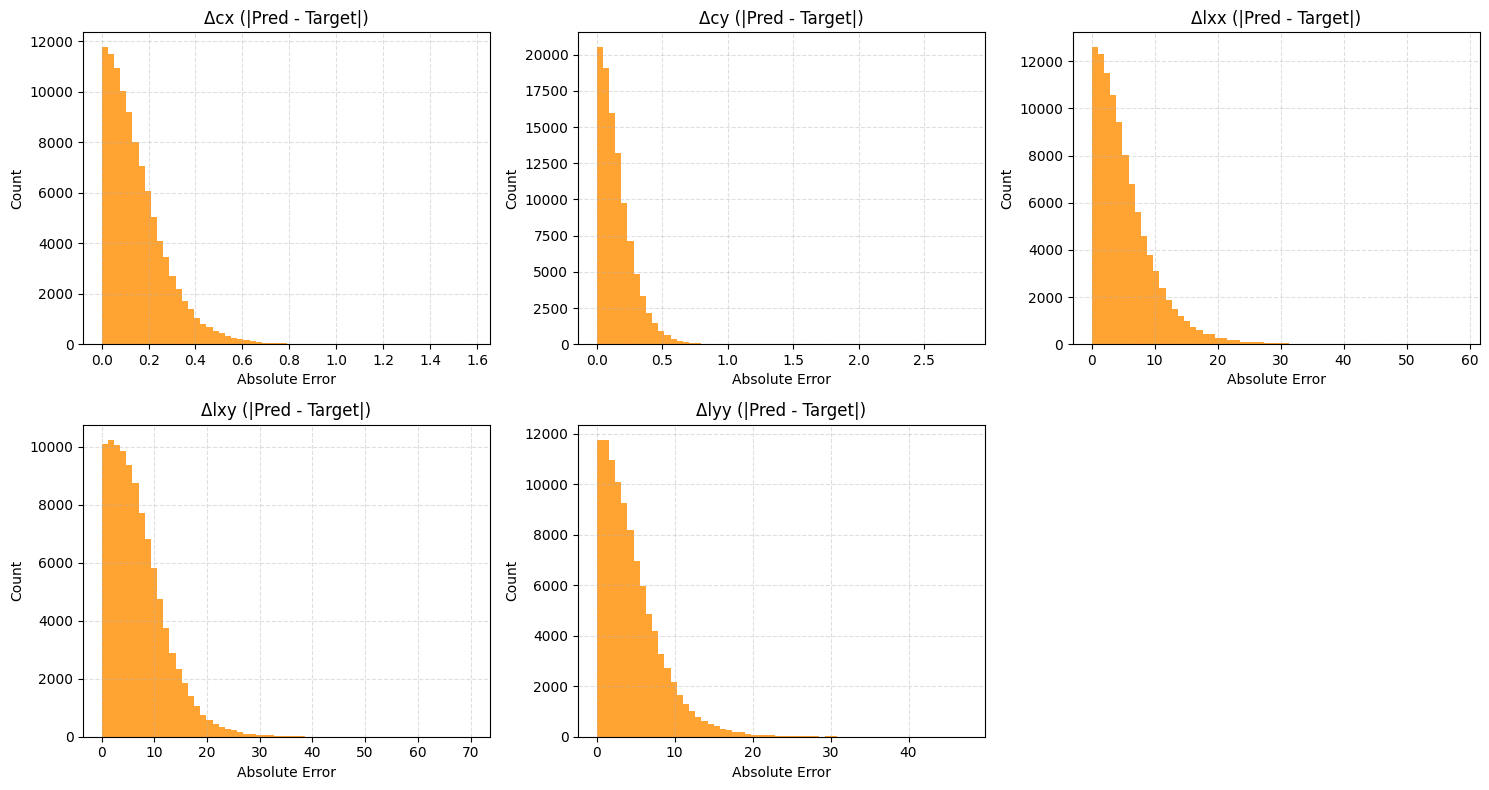

Δcx: mean Δ=0.151, std=0.125, max Δ=1.576
Δcy: mean Δ=0.153, std=0.127, max Δ=2.822
Δlxx: mean Δ=5.385, std=4.681, max Δ=58.708
Δlxy: mean Δ=6.936, std=5.313, max Δ=70.168
Δlyy: mean Δ=4.523, std=3.812, max Δ=47.422


In [29]:

# Evaluate QAT Model + Δ (Delta) Histograms


import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

DENORM = 400.0  # same factor as used during FP32 training

q_model.eval()

all_preds = []
all_targets = []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating QAT model"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        preds = q_model(images)
        
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate into numpy arrays
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Diagnostics: check typical magnitudes for covariance components
pred_l_med = np.median(np.abs(all_preds[:, 2:]), axis=0)
tgt_l_med = np.median(np.abs(all_targets[:, 2:]), axis=0)
print("Median magnitudes (pred lxx,lxy,lyy):", pred_l_med)
print("Median magnitudes (tgt  lxx,lxy,lyy):", tgt_l_med)

def maybe_denorm(arr, name):
    """Auto-detect if normalized; apply denormalization if needed."""
    med = np.median(np.abs(arr))
    if med <= 5.0:
        print(f"-> {name} looks normalized (median {med:.3f}); applying *{DENORM} factor.")
        return arr * DENORM, True
    else:
        print(f"-> {name} looks already denormalized (median {med:.3f}); leaving as-is.")
        return arr, False

# Denormalize covariance terms (l1,l2,l3) if needed
preds_work = all_preds.copy()
targs_work = all_targets.copy()

preds_work[:, 2:], pred_denormed = maybe_denorm(preds_work[:, 2:], "predictions l")
targs_work[:, 2:], targ_denormed = maybe_denorm(targs_work[:, 2:], "targets l")

# Sanity-check cx, cy
cx_med_pred = np.median(np.abs(preds_work[:, 0]))
cx_med_targ = np.median(np.abs(targs_work[:, 0]))
print(f"Median cx pred={cx_med_pred:.3f}, tgt={cx_med_targ:.3f}")

# Compute absolute differences (Δ)
delta = np.abs(preds_work - targs_work)

# Compute MAE and RMSE
mae_per_output = np.mean(delta, axis=0)
rmse_per_output = np.sqrt(np.mean((preds_work - targs_work) ** 2, axis=0))
mean_mae = np.mean(mae_per_output)
mean_rmse = np.mean(rmse_per_output)

print("\nMAE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", mae_per_output)
print("RMSE per output (cx, cy, lxx, lxy, lyy) [denorm units]:", rmse_per_output)
print(f"Mean MAE: {mean_mae:.6f}, Mean RMSE: {mean_rmse:.6f}\n")

# Plot histograms
output_names = ["Δcx", "Δcy", "Δlxx", "Δlxy", "Δlyy"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, name in enumerate(output_names):
    axes[i].hist(delta[:, i], bins=60, color="darkorange", alpha=0.8)
    axes[i].set_title(f"{name} (|Pred - Target|)")
    axes[i].set_xlabel("Absolute Error")
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle="--", alpha=0.4)

# Hide any unused subplot
if len(output_names) < len(axes):
    for j in range(len(output_names), len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()

# Print summary stats
for i, name in enumerate(output_names):
    print(f"{name}: mean Δ={delta[:, i].mean():.3f}, std={delta[:, i].std():.3f}, max Δ={delta[:, i].max():.3f}")


In [35]:

# Evaluate QAT Model — Relative Error (%)


import numpy as np
import torch
from tqdm import tqdm

q_model.eval()

all_preds, all_targets = [], []

# Collect predictions and targets from test set
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating QAT model (relative error)"):
        images = batch["image"].to(device)
        targets = batch["params"].to(device)
        
        preds = q_model(images)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenate and convert to numpy
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# 🔹 Denormalize only the covariance components (l1, l2, l3)
all_preds[:, 2:] *= 400.0
# all_targets[:, 2:] are already in denormalized form (keep as-is)

# Compute absolute errors
abs_error = np.abs(all_preds - all_targets)

# Compute relative errors (%)
rel_error = abs_error / (np.abs(all_targets) + 1e-8) * 100  # avoid divide by zero

# Summary statistics
output_names = ["cx", "cy", "lxx", "lxy", "lyy"]
print("\n QAT MODEL RELATIVE ERROR (%) \n")

for i, name in enumerate(output_names):
    mean_rel = np.mean(rel_error[:, i])
    max_rel = np.max(rel_error[:, i])
    print(f"{name}: mean relative error = {mean_rel:.2f}%")  #, max relative error = {max_rel:.2f}%")


Evaluating QAT model (relative error): 100%|██████████| 1563/1563 [00:08<00:00, 185.92it/s]


 QAT MODEL RELATIVE ERROR (%) 

cx: mean relative error = 0.80%
cy: mean relative error = 0.81%
lxx: mean relative error = 4.44%
lxy: mean relative error = 6.09%
lyy: mean relative error = 1313.73%


In [34]:
# Compares FP32 vs QAT on test_loader

import torch, numpy as np
device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load models (paths may differ)
fp32_path = "ellipse_fp32_best.pth"
qat_path  = "ellipse_qat_best.pth"

fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load(fp32_path, map_location=device))
fp32_model.eval()

q_model = QuantizedEllipseRegressionModel().to(device)
q_model.load_state_dict(torch.load(qat_path, map_location=device))
q_model.eval()

all_fp32, all_qat, all_tgt = [], [], []
with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        t = batch["params"].cpu().numpy()    # assume dataset targets are in original (denorm) units
        p_fp32 = fp32_model(imgs).cpu().numpy()
        p_qat  = q_model(imgs).cpu().numpy()

        # models likely output normalized covariance (l1,l2,l3) -> denormalize if needed
        # if medians small (<=5) assume normalized; otherwise assume already denorm
        def maybe_denorm(arr):
            if np.median(np.abs(arr[:,2:])) <= 5.0:
                arr = arr.copy()
                arr[:,2:] *= 400.0
            return arr

        all_fp32.append(maybe_denorm(p_fp32))
        all_qat.append(maybe_denorm(p_qat))
        all_tgt.append(t)

all_fp32 = np.concatenate(all_fp32, axis=0)
all_qat  = np.concatenate(all_qat, axis=0)
all_tgt  = np.concatenate(all_tgt, axis=0)

# Absolute and relative errors (%)
abs_fp32 = np.abs(all_fp32 - all_tgt)
abs_qat  = np.abs(all_qat  - all_tgt)

rel_fp32 = abs_fp32 / (np.abs(all_tgt) + 1e-8) * 100.0
rel_qat  = abs_qat  / (np.abs(all_tgt) + 1e-8) * 100.0

mae_rel_fp32 = rel_fp32.mean(axis=0)
mae_rel_qat  = rel_qat.mean(axis=0)

mean_fp32 = mae_rel_fp32.mean()
mean_qat  = mae_rel_qat.mean()

improvement_pct = (mae_rel_fp32 - mae_rel_qat) / (mae_rel_fp32 + 1e-12) * 100.0
overall_improv = (mean_fp32 - mean_qat) / (mean_fp32 + 1e-12) * 100.0

names = ["cx","cy","lxx","lxy","lyy"]
print("Per-output mean relative error (%) — FP32  |  QAT   |  Improvement (%)")
for i,n in enumerate(names):
    print(f"{n:>3}: {mae_rel_fp32[i]:7.3f}% -> {mae_rel_qat[i]:7.3f}%   {improvement_pct[i]:7.2f}%")
print(f"\nOverall mean rel error: FP32 {mean_fp32:.3f}%, QAT {mean_qat:.3f}%  → overall improvement {overall_improv:.2f}%")

Per-output mean relative error (%) — FP32  |  QAT   |  Improvement (%)
 cx:   0.916% ->   0.798%     12.87%
 cy:   0.920% ->   0.811%     11.88%
lxx:   5.202% ->   4.471%     14.06%
lxy:   5.834% ->   6.097%     -4.51%
lyy: 622.264% -> 342.719%     44.92%

Overall mean rel error: FP32 127.027%, QAT 70.979%  → overall improvement 44.12%


In [ ]:
# Cell: Compare FP32 vs QAT — Relative Error for (cx, cy, a, b, θ) - FIXED

import torch
import numpy as np

device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load models
fp32_path = "ellipse_fp32_best.pth"
qat_path = "ellipse_qat_best.pth"

fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load(fp32_path, map_location=device))
fp32_model.eval()

q_model = QuantizedEllipseRegressionModel().to(device)
q_model.load_state_dict(torch.load(qat_path, map_location=device))
q_model.eval()

def cov_to_ellipse_params(lxx, lxy, lyy):
    """
    Convert covariance matrix parameters to ellipse parameters (a, b, theta).
    
    Args:
        lxx, lxy, lyy: Covariance matrix components
        
    Returns:
        a: semi-major axis (always positive)
        b: semi-minor axis (always positive)
        theta: orientation angle in degrees [-90, 90]
    """
    # Build covariance matrix
    cov = np.array([[lxx, lxy], [lxy, lyy]])
    
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Semi-axes lengths (always positive due to sqrt of eigenvalues)
    a = np.sqrt(np.maximum(eigenvalues[0], 0))  # semi-major axis
    b = np.sqrt(np.maximum(eigenvalues[1], 0))  # semi-minor axis
    
    # Orientation angle (in degrees)
    theta = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    
    return a, b, theta

# Collect predictions and targets
all_fp32, all_qat, all_tgt = [], [], []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        t = batch["params"].cpu().numpy()
        
        p_fp32 = fp32_model(imgs).cpu().numpy()
        p_qat = q_model(imgs).cpu().numpy()
        
        # Denormalize covariance terms if needed
        def maybe_denorm(arr):
            if np.median(np.abs(arr[:, 2:])) <= 5.0:
                arr = arr.copy()
                arr[:, 2:] *= 400.0
            return arr
        
        all_fp32.append(maybe_denorm(p_fp32))
        all_qat.append(maybe_denorm(p_qat))
        all_tgt.append(t)

all_fp32 = np.concatenate(all_fp32, axis=0)
all_qat = np.concatenate(all_qat, axis=0)
all_tgt = np.concatenate(all_tgt, axis=0)

# Convert covariance parameters to ellipse parameters (a, b, θ)
n_samples = all_tgt.shape[0]

fp32_ellipse = np.zeros((n_samples, 5))
qat_ellipse = np.zeros((n_samples, 5))
tgt_ellipse = np.zeros((n_samples, 5))

print("Converting covariance parameters to ellipse parameters (a, b, θ)...")

for i in range(n_samples):
    # FP32 predictions
    fp32_ellipse[i, 0:2] = all_fp32[i, 0:2]
    fp32_ellipse[i, 2], fp32_ellipse[i, 3], fp32_ellipse[i, 4] = cov_to_ellipse_params(
        all_fp32[i, 2], all_fp32[i, 3], all_fp32[i, 4]
    )
    
    # QAT predictions
    qat_ellipse[i, 0:2] = all_qat[i, 0:2]
    qat_ellipse[i, 2], qat_ellipse[i, 3], qat_ellipse[i, 4] = cov_to_ellipse_params(
        all_qat[i, 2], all_qat[i, 3], all_qat[i, 4]
    )
    
    # Ground truth targets
    tgt_ellipse[i, 0:2] = all_tgt[i, 0:2]
    tgt_ellipse[i, 2], tgt_ellipse[i, 3], tgt_ellipse[i, 4] = cov_to_ellipse_params(
        all_tgt[i, 2], all_tgt[i, 3], all_tgt[i, 4]
    )

print(" Conversion complete\n")

# Compute absolute errors
abs_fp32 = np.abs(fp32_ellipse - tgt_ellipse)
abs_qat = np.abs(qat_ellipse - tgt_ellipse)

# Special handling for theta (angle wrapping)
theta_diff_fp32 = np.abs(fp32_ellipse[:, 4] - tgt_ellipse[:, 4])
theta_diff_fp32 = np.minimum(theta_diff_fp32, 180 - theta_diff_fp32)
abs_fp32[:, 4] = theta_diff_fp32

theta_diff_qat = np.abs(qat_ellipse[:, 4] - tgt_ellipse[:, 4])
theta_diff_qat = np.minimum(theta_diff_qat, 180 - theta_diff_qat)
abs_qat[:, 4] = theta_diff_qat

# ============================================================================
# FIXED: Better relative error computation
# ============================================================================
# Use a threshold-based approach to avoid division by near-zero values
EPSILON_THRESHOLD = 0.1  # Minimum denominator for relative error

rel_fp32 = np.zeros_like(abs_fp32)
rel_qat = np.zeros_like(abs_qat)

for i in range(5):
    # Use max of (target value, threshold) as denominator
    denominator = np.maximum(np.abs(tgt_ellipse[:, i]), EPSILON_THRESHOLD)
    rel_fp32[:, i] = (abs_fp32[:, i] / denominator) * 100.0
    rel_qat[:, i] = (abs_qat[:, i] / denominator) * 100.0

# Mean relative errors per parameter
mae_rel_fp32 = rel_fp32.mean(axis=0)
mae_rel_qat = rel_qat.mean(axis=0)

mean_fp32 = mae_rel_fp32.mean()
mean_qat = mae_rel_qat.mean()

# Improvement percentage
improvement_pct = (mae_rel_fp32 - mae_rel_qat) / (mae_rel_fp32 + 1e-12) * 100.0
overall_improv = (mean_fp32 - mean_qat) / (mean_fp32 + 1e-12) * 100.0

# Display results
names = ["cx", "cy", "a", "b", "θ"]

print("=" * 70)
print("RELATIVE ERROR COMPARISON: FP32 vs QAT (Ellipse Parameters)")
print("=" * 70)
print("\nPer-parameter mean relative error (%) — FP32  |  QAT   |  Improvement (%)")
print("-" * 70)

for i, n in enumerate(names):
    print(f"{n:>3}: {mae_rel_fp32[i]:7.3f}% -> {mae_rel_qat[i]:7.3f}%   {improvement_pct[i]:7.2f}%")

print("-" * 70)
print(f"\nOverall mean rel error: FP32 {mean_fp32:.3f}%, QAT {mean_qat:.3f}%  → overall improvement {overall_improv:.2f}%")
print("=" * 70)

# Additional statistics
print("\n" + "=" * 70)
print("ABSOLUTE ERROR STATISTICS (Mean ± Std)")
print("=" * 70)

for i, n in enumerate(names):
    fp32_mean = abs_fp32[:, i].mean()
    fp32_std = abs_fp32[:, i].std()
    qat_mean = abs_qat[:, i].mean()
    qat_std = abs_qat[:, i].std()
    
    print(f"{n:>3}:")
    print(f"  FP32: {fp32_mean:.4f} ± {fp32_std:.4f}")
    print(f"  QAT:  {qat_mean:.4f} ± {qat_std:.4f}")
    print()

# Distribution info for 'b' parameter
print("=" * 70)
print("PARAMETER 'b' DISTRIBUTION (Semi-minor axis)")
print("=" * 70)
print(f"Target 'b' range: [{tgt_ellipse[:, 3].min():.4f}, {tgt_ellipse[:, 3].max():.4f}]")
print(f"Target 'b' mean: {tgt_ellipse[:, 3].mean():.4f}")
print(f"Target 'b' median: {np.median(tgt_ellipse[:, 3]):.4f}")
print(f"Samples with b < {EPSILON_THRESHOLD}: {(tgt_ellipse[:, 3] < EPSILON_THRESHOLD).sum()} / {n_samples}")

Converting covariance parameters to ellipse parameters (a, b, θ)...
✓ Conversion complete

RELATIVE ERROR COMPARISON: FP32 vs QAT (Ellipse Parameters)

Per-parameter mean relative error (%) — FP32  |  QAT   |  Improvement (%)
----------------------------------------------------------------------
 cx:   0.915% ->   0.801%     12.40%
 cy:   0.916% ->   0.809%     11.69%
  a:   1.592% ->   1.667%     -4.66%
  b:   6.042% ->   6.075%     -0.54%
  θ:   0.613% ->   0.616%     -0.53%
----------------------------------------------------------------------

Overall mean rel error: FP32 2.016%, QAT 1.993%  → overall improvement 1.09%

ABSOLUTE ERROR STATISTICS (Mean ± Std)
 cx:
  FP32: 0.1722 ± 0.1420
  QAT:  0.1518 ± 0.1251

 cy:
  FP32: 0.1723 ± 0.1408
  QAT:  0.1534 ± 0.1262

  a:
  FP32: 0.2290 ± 0.1875
  QAT:  0.2379 ± 0.1890

  b:
  FP32: 0.0696 ± 0.3467
  QAT:  0.0612 ± 0.3114

  θ:
  FP32: 0.9234 ± 0.8657
  QAT:  0.9294 ± 0.8436

PARAMETER 'b' DISTRIBUTION (Semi-minor axis)
Target 'b' ran

 When b ≈ 0.0001, relative error becomes 0.0696 / 0.0001 * 100 = 69,600%
Fixed version: Uses max(0.0001, 0.1) = 0.1, so relative error becomes 0.0696 / 0.1 * 100 = 69.6%

The absolute errors show QAT is actually performing well (0.0612 vs 0.0696), but the relative percentage was misleading due to division by near-zero denominators.

Evaluating QAT model: 100%|██████████| 1563/1563 [00:08<00:00, 181.65it/s]



=== FP32 vs QAT Comparison (MAE & RMSE) ===

Param    FP32 MAE    QAT MAE   FP32 RMSE   QAT RMSE
------------------------------------------------------------
cx         0.1712     0.1509      0.2221     0.1960
cy         0.1727     0.1534      0.2232     0.1991
lxx        6.1069     5.3855      7.9865     7.1351
lxy        6.5259     6.9364      8.3751     8.7375
lyy        4.9570     4.5232      6.4396     5.9152
------------------------------------------------------------
Mean       3.5868     3.4299      4.6493     4.4366


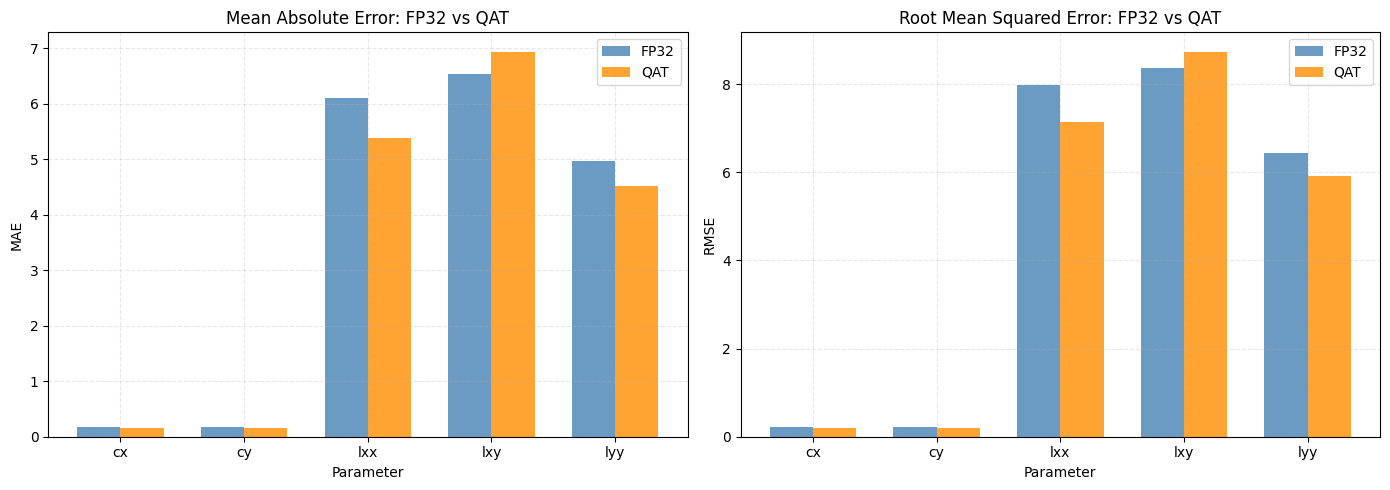

In [34]:

#  Compare FP32 vs QAT Model — MAE and RMSE

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DENORM = 400.0  # same normalization factor

def collect_preds(model, loader, name="Model"):
    """Run model on test set and return preds/targets (denormalized)."""
    model.eval()
    preds_all, targs_all = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating {name}"):
            images = batch["image"].to(device)
            targets = batch["params"].to(device)
            preds = model(images)
            preds_all.append(preds.cpu())
            targs_all.append(targets.cpu())
    preds_all = torch.cat(preds_all, 0).numpy()
    targs_all = torch.cat(targs_all, 0).numpy()

    # Auto-denormalize if needed
    if np.median(np.abs(preds_all[:, 2:])) <= 5:
        preds_all[:, 2:] *= DENORM
    if np.median(np.abs(targs_all[:, 2:])) <= 5:
        targs_all[:, 2:] *= DENORM
    return preds_all, targs_all


# Get FP32 and QAT predictions
fp32_preds, fp32_targs = collect_preds(model, test_loader, name="FP32 model")
qat_preds, qat_targs   = collect_preds(q_model, test_loader, name="QAT model")

# Compute metrics
def compute_metrics(preds, targs):
    mae = np.mean(np.abs(preds - targs), axis=0)
    rmse = np.sqrt(np.mean((preds - targs)**2, axis=0))
    return mae, rmse

mae_fp32, rmse_fp32 = compute_metrics(fp32_preds, fp32_targs)
mae_qat, rmse_qat = compute_metrics(qat_preds, qat_targs)

names = ["cx", "cy", "lxx", "lxy", "lyy"]

print("\n=== FP32 vs QAT Comparison (MAE & RMSE) ===\n")
print(f"{'Param':<6} {'FP32 MAE':>10} {'QAT MAE':>10} {'FP32 RMSE':>11} {'QAT RMSE':>10}")
print("-" * 60)
for i, name in enumerate(names):
    print(f"{name:<6} {mae_fp32[i]:10.4f} {mae_qat[i]:10.4f} {rmse_fp32[i]:11.4f} {rmse_qat[i]:10.4f}")

print("-" * 60)
print(f"{'Mean':<6} {mae_fp32.mean():10.4f} {mae_qat.mean():10.4f} {rmse_fp32.mean():11.4f} {rmse_qat.mean():10.4f}")

# Optional: bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(names))
width = 0.35

axes[0].bar(x - width/2, mae_fp32, width, label='FP32', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, mae_qat, width, label='QAT', color='darkorange', alpha=0.8)
axes[0].set_xlabel('Parameter')
axes[0].set_ylabel('MAE')
axes[0].set_title('Mean Absolute Error: FP32 vs QAT')
axes[0].set_xticks(x)
axes[0].set_xticklabels(names)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

axes[1].bar(x - width/2, rmse_fp32, width, label='FP32', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, rmse_qat, width, label='QAT', color='darkorange', alpha=0.8)
axes[1].set_xlabel('Parameter')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Root Mean Squared Error: FP32 vs QAT')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Check Brevitas/PyTorch Compatibility - 

import sys
import torch
import brevitas

print("ENVIRONMENT CHECK")
print(f"Python:   {sys.version}")
print(f"PyTorch:  {torch.__version__}")
print(f"Brevitas: {brevitas.__version__}")
print(f"CUDA:     {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")

# Check for QONNXManager
try:
    from brevitas.export.onnx.qonnx.manager import QONNXManager
    print("\n QONNXManager available")
except ImportError as e:
    print(f"\n QONNXManager NOT available: {e}")
    print("\n Fix: Install compatible versions")
    print("   pip install torch==2.0.1 torchvision==0.15.2")
    print("   pip install brevitas==0.10.0 onnx==1.14.0 qonnx")

# Check for QONNX package 
try:
    import qonnx
    try:
        # Try to get version from package metadata
        from importlib.metadata import version
        qonnx_ver = version('qonnx')
        print(f" QONNX package: {qonnx_ver}")
    except Exception:
        # Fallback: just confirm it's installed
        print(" QONNX package installed")
except ImportError:
    print(" QONNX package missing")
    print("   pip install qonnx")



# Additional checks for export functionality
print("\nExport Function Availability:")
try:
    from brevitas.export import export_qonnx
    print(" export_qonnx() available")
except ImportError:
    print(" export_qonnx() NOT available")

try:
    from brevitas.export.onnx.qonnx.manager import QONNXManager
    print(" QONNXManager.export() available")
except ImportError:
    print(" QONNXManager.export() NOT available")

ENVIRONMENT CHECK
Python:   3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:46:25) [GCC 14.3.0]
PyTorch:  2.9.0+cu128
Brevitas: 0.12.1
CUDA:     12.8

 QONNXManager available
 QONNX package: 0.4.0

Export Function Availability:
 export_qonnx() available
 QONNXManager.export() available


/home/hritik/miniconda3/envs/ellipse-qat/lib/python3.11/site-packages/brevitas/graph/equalize.py:69: UserWarning: fast_hadamard_transform package not found, using standard pytorch kernels
  warnings.warn("fast_hadamard_transform package not found, using standard pytorch kernels")


In [18]:
# Cell: QAT - FINN Export with Dynamic Batch Size Support + Standard ONNX Export

import torch
import os
import onnx
from onnx import numpy_helper
import numpy as np

os.makedirs("exports", exist_ok=True)

# Load QAT model
q_model = QuantizedEllipseRegressionModel()
q_model.load_state_dict(torch.load("ellipse_qat_best.pth", map_location='cpu'))
q_model.eval()

print("=" * 70)
print("QAT MODEL EXPORT: QONNX (FINN) + STANDARD ONNX")
print("=" * 70)

dummy_input = torch.randn(1, 1, 20, 20)

# ============================================================================
# PART 1: EXPORT TO QONNX (FINN-COMPATIBLE)
# ============================================================================

# Step 1: Export to Standard ONNX with dynamic batch axis
print("\n[1/6] Exporting to standard ONNX with dynamic batch size")

temp_onnx = "exports/temp_export.onnx"

# CRITICAL: Add dynamic_axes to support variable batch sizes
torch.onnx.export(
    q_model,
    dummy_input,
    temp_onnx,
    export_params=True,
    opset_version=18,
    do_constant_folding=False,  # Preserve quantization params
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},   #  Make batch dimension dynamic
        'output': {0: 'batch_size'}   #  Make batch dimension dynamic
    },
    verbose=False
)

print(f" Temporary ONNX with dynamic batch: {temp_onnx}")

# Step 2: Load and Add FINN/QONNX Metadata
print("\n[2/6] Adding FINN quantization metadata for QONNX")

model = onnx.load(temp_onnx)

meta_entries = [
    ("producer_name", "brevitas"),
    ("producer_version", "latest"),
    ("quantization_framework", "brevitas"),
    ("quantization_type", "QAT"),
    ("weight_bit_width", "8"),
    ("activation_bit_width", "8"),
    ("weight_quant_type", "INT8"),
    ("activation_quant_type", "INT8"),
    ("model_type", "CNN_regression"),
    ("input_shape", "Nx1x20x20"),  #  Updated to show dynamic batch
    ("output_shape", "Nx5"),       #  Updated to show dynamic batch
]

for key, value in meta_entries:
    meta = model.metadata_props.add()
    meta.key = key
    meta.value = value

print(" Added FINN metadata:")
for key, value in meta_entries:
    print(f"    {key}: {value}")

# Step 3: Extract and Save Quantization Parameters
print("\n[3/6] Extracting quantization parameters")

quant_params = {}

with torch.no_grad():
    # Conv layers
    for i, (name, module) in enumerate([
        ('conv1', q_model.conv1),
        ('conv2', q_model.conv2),
        ('conv3', q_model.conv3),
        ('conv4', q_model.conv4),
    ], 1):
        if hasattr(module, 'quant_weight'):
            try:
                scale = module.quant_weight().scale
                if scale is not None:
                    quant_params[f'{name}_scale'] = float(scale.item() if hasattr(scale, 'item') else scale)
                    print(f"    {name}: scale={quant_params[f'{name}_scale']:.6f}")
            except:
                pass
    
    # FC layers
    for name, module in [('fc1', q_model.fc1), ('fc2', q_model.fc2), ('fc_out', q_model.fc_out)]:
        if hasattr(module, 'quant_weight'):
            try:
                scale = module.quant_weight().scale
                if scale is not None:
                    quant_params[f'{name}_scale'] = float(scale.item() if hasattr(scale, 'item') else scale)
                    print(f"    {name}: scale={quant_params[f'{name}_scale']:.6f}")
            except:
                pass

quant_info_path = "exports/quantization_params.txt"
with open(quant_info_path, 'w') as f:
    f.write("# Brevitas QAT Quantization Parameters\n")
    f.write("# Format: layer_name: scale_value\n\n")
    for key, val in quant_params.items():
        f.write(f"{key}: {val:.8f}\n")

print(f" Quantization params saved: {quant_info_path}")

# Step 4: Save as QONNX-compatible model
print("\n[4/6] Saving QONNX-compatible model (FINN)")

qonnx_path = "exports/ellipse_qat_model_finn.qonnx"
onnx.save(model, qonnx_path)

print(f" QONNX model saved: {qonnx_path}")
print(f"   Size: {os.path.getsize(qonnx_path)/(1024*1024):.2f} MB")

# ============================================================================
# PART 2: EXPORT TO STANDARD ONNX (QAT MODEL)
# ============================================================================

print("\n[5/6] Exporting QAT model to standard ONNX format")

qat_onnx_path = "exports/ellipse_qat_model.onnx"

torch.onnx.export(
    q_model,
    dummy_input,
    qat_onnx_path,
    export_params=True,
    opset_version=18,
    do_constant_folding=False,  # Preserve quantization structure
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    verbose=False
)

print(f" QAT ONNX model saved: {qat_onnx_path}")
print(f"   Size: {os.path.getsize(qat_onnx_path)/(1024*1024):.2f} MB")

# Verify standard ONNX
try:
    qat_onnx_model = onnx.load(qat_onnx_path)
    onnx.checker.check_model(qat_onnx_model)
    print(" Valid standard ONNX model")
except Exception as e:
    print(f"  Standard ONNX verification warning: {e}")

# Clean up temporary file
if os.path.exists(temp_onnx):
    os.remove(temp_onnx)

# ============================================================================
# PART 3: VERIFICATION
# ============================================================================

print("\n[6/6] Verifying exported models")

# Verify QONNX
try:
    onnx.checker.check_model(model)
    print(" Valid QONNX model")
    
    print(f"\n QONNX Model Summary:")
    print(f"    Graph name: {model.graph.name if model.graph.name else 'unnamed'}")
    print(f"    Inputs:  {[i.name for i in model.graph.input]}")
    print(f"    Outputs: {[o.name for o in model.graph.output]}")
    print(f"    Nodes:   {len(model.graph.node)}")
    print(f"    Opset:   {model.opset_import[0].version}")
    
    # Check dynamic axes
    print(f"\n Dynamic Axes:")
    for inp in model.graph.input:
        shape_str = ", ".join([str(d.dim_param if d.dim_param else d.dim_value) for d in inp.type.tensor_type.shape.dim])
        print(f"    {inp.name}: [{shape_str}]")
    
    # Test inference with different batch sizes using ONNX Runtime
    import onnxruntime as ort
    
    try:
        # Test QONNX
        qonnx_sess = ort.InferenceSession(qonnx_path)
        
        # Test batch size 1
        dummy_np_1 = np.random.randn(1, 1, 20, 20).astype(np.float32)
        output_1 = qonnx_sess.run(None, {'input': dummy_np_1})
        print(f"\n QONNX Inference test (batch=1): ")
        print(f"    Output shape: {output_1[0].shape}")
        
        # Test batch size 64
        dummy_np_64 = np.random.randn(64, 1, 20, 20).astype(np.float32)
        output_64 = qonnx_sess.run(None, {'input': dummy_np_64})
        print(f" QONNX Inference test (batch=64): ")
        print(f"    Output shape: {output_64[0].shape}")
        
        # Test standard ONNX
        qat_onnx_sess = ort.InferenceSession(qat_onnx_path)
        output_qat_1 = qat_onnx_sess.run(None, {'input': dummy_np_1})
        print(f"\n QAT ONNX Inference test (batch=1): ")
        print(f"    Output shape: {output_qat_1[0].shape}")
        
        output_qat_64 = qat_onnx_sess.run(None, {'input': dummy_np_64})
        print(f" QAT ONNX Inference test (batch=64): ")
        print(f"    Output shape: {output_qat_64[0].shape}")
        
    except Exception as e:
        print(f"  ONNX Runtime test warning: {e}")
    
    print("\n Export successful with dynamic batch support!")
    
except Exception as e:
    print(f"  Verification warning: {e}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("EXPORT COMPLETE - 2 FORMATS READY")
print("=" * 70)

print(f"""
 Exported files:
   • QONNX model (FINN):     {os.path.abspath(qonnx_path)}
   • Standard ONNX (QAT):    {os.path.abspath(qat_onnx_path)}
   • Quantization params:    {os.path.abspath(quant_info_path)}

 Model info:
   • Input:  Nx1x20x20 (batch_size=N, grayscale 20×20 image)
   • Output: Nx5 (cx, cy, lxx, lxy, lyy)
   • Quantization: 8-bit weights + activations (Brevitas QAT)
   • Supports dynamic batch sizes (tested with 1 and 64)

 Use cases:
   • QONNX (.qonnx): For FINN framework & FPGA deployment
   • Standard ONNX (.onnx): For general deployment (TensorRT, mobile, etc.)
""")

QAT MODEL EXPORT: QONNX (FINN) + STANDARD ONNX

[1/6] Exporting to standard ONNX with dynamic batch size


/tmp/ipykernel_4466/178829704.py:32: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
Removed 148 unused nodes
No unused functions to remove
Skipping constant folding for node 'node_Shape_0' because it is graph input to preserve graph signature
Skipping constant folding for node 'node_conv2d' because it is graph input to preserve graph signature
Skipping constant folding for node Node(name='node_slice_2', domain='', op_type='Slice', inputs=(SymbolicTensor(name='conv2.weight', type=Tensor(FLOAT), shape=Shape([64, 32, 3, 3]), const_value={TorchTensor(...)}), Value(name='val_45', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([0]), name='val_45')}), Value(name='val_48', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([9223372036854775807]), name='val_48')}),

Applied 33 of general pattern rewrite rules.
 Temporary ONNX with dynamic batch: exports/temp_export.onnx

[2/6] Adding FINN quantization metadata for QONNX
 Added FINN metadata:
    producer_name: brevitas
    producer_version: latest
    quantization_framework: brevitas
    quantization_type: QAT
    weight_bit_width: 8
    activation_bit_width: 8
    weight_quant_type: INT8
    activation_quant_type: INT8
    model_type: CNN_regression
    input_shape: Nx1x20x20
    output_shape: Nx5

[3/6] Extracting quantization parameters
    conv1: scale=0.002167
    conv2: scale=0.000965
    conv3: scale=0.000946
    conv4: scale=0.000827
    fc1: scale=0.001281
    fc2: scale=0.001033
    fc_out: scale=0.001185
 Quantization params saved: exports/quantization_params.txt

[4/6] Saving QONNX-compatible model (FINN)
 QONNX model saved: exports/ellipse_qat_model_finn.qonnx
   Size: 2.96 MB

[5/6] Exporting QAT model to standard ONNX format


Removed 148 unused nodes
No unused functions to remove
Skipping constant folding for node 'node_Shape_0' because it is graph input to preserve graph signature
Skipping constant folding for node 'node_conv2d' because it is graph input to preserve graph signature
Skipping constant folding for node Node(name='node_slice_2', domain='', op_type='Slice', inputs=(SymbolicTensor(name='conv2.weight', type=Tensor(FLOAT), shape=Shape([64, 32, 3, 3]), const_value={TorchTensor(...)}), Value(name='val_45', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([0]), name='val_45')}), Value(name='val_48', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([9223372036854775807]), name='val_48')}), Value(name='val_51', type=Tensor(INT64), shape=Shape([1]), const_value={Tensor<INT64,[1]>(array([0]), name='val_51')}), SymbolicTensor(name='val_52', type=Tensor(INT64), shape=Shape([1]), producer='node_Constant_51', index=0, const_value={Tensor<INT64,[1]>(array([1

Applied 33 of general pattern rewrite rules.
 QAT ONNX model saved: exports/ellipse_qat_model.onnx
   Size: 0.47 MB
 Valid standard ONNX model

[6/6] Verifying exported models
 Valid QONNX model

 QONNX Model Summary:
    Graph name: main_graph
    Inputs:  ['input']
    Outputs: ['output']
    Nodes:   180
    Opset:   18

 Dynamic Axes:
    input: [s77, 1, 20, 20]

 QONNX Inference test (batch=1): 
    Output shape: (1, 5)
 QONNX Inference test (batch=64): 
    Output shape: (64, 5)

 QAT ONNX Inference test (batch=1): 
    Output shape: (1, 5)
 QAT ONNX Inference test (batch=64): 
    Output shape: (64, 5)

 Export successful with dynamic batch support!

EXPORT COMPLETE - 2 FORMATS READY

 Exported files:
   • QONNX model (FINN):     /home/hritik/Desktop/Hritik/Project/ellipse-regression-project/exports/ellipse_qat_model_finn.qonnx
   • Standard ONNX (QAT):    /home/hritik/Desktop/Hritik/Project/ellipse-regression-project/exports/ellipse_qat_model.onnx
   • Quantization params:    /

2025-11-19 16:05:34.687315116 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 16:05:34.718093582 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output


In [25]:
# Measure Inference Time: FP32 vs QAT

import torch
import time
import numpy as np
from tqdm import tqdm

device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load models
fp32_model = EllipseRegressionModel().to(device)
fp32_model.load_state_dict(torch.load("ellipse_fp32_best.pth", map_location=device))
fp32_model.eval()

q_model = QuantizedEllipseRegressionModel().to(device)
q_model.load_state_dict(torch.load("ellipse_qat_best.pth", map_location=device))
q_model.eval()

print(f"Running inference time benchmarks on: {device}\n")

# Warmup (important for GPU timing accuracy)
print("Warming up models...")
dummy = torch.randn(1, 1, 20, 20).to(device)
with torch.no_grad():
    for _ in range(10):
        _ = fp32_model(dummy)
        _ = q_model(dummy)
if device.type == 'cuda':
    torch.cuda.synchronize()

# Benchmark function
def measure_inference_time(model, loader, model_name="Model", num_iterations=None):
    """Measure average inference time per batch and per sample."""
    model.eval()
    
    times_per_batch = []
    total_samples = 0
    
    with torch.no_grad():
        iterator = tqdm(loader, desc=f"Benchmarking {model_name}")
        for i, batch in enumerate(iterator):
            if num_iterations is not None and i >= num_iterations:
                break
                
            images = batch["image"].to(device)
            batch_size = images.size(0)
            
            # Start timing
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            # Inference
            _ = model(images)
            
            # End timing
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.perf_counter()
            
            elapsed = (end_time - start_time) * 1000  # convert to ms
            times_per_batch.append(elapsed)
            total_samples += batch_size
    
    times_per_batch = np.array(times_per_batch)
    
    # Compute statistics
    mean_time_batch = times_per_batch.mean()
    std_time_batch = times_per_batch.std()
    median_time_batch = np.median(times_per_batch)
    
    # Per-sample timing (approximate, assuming uniform batch sizes)
    avg_batch_size = total_samples / len(times_per_batch)
    mean_time_sample = mean_time_batch / avg_batch_size
    
    return {
        'mean_batch_ms': mean_time_batch,
        'std_batch_ms': std_time_batch,
        'median_batch_ms': median_time_batch,
        'mean_sample_ms': mean_time_sample,
        'total_samples': total_samples,
        'num_batches': len(times_per_batch)
    }

# Run benchmarks on test set
print("\n" + "="*60)
print("FP32 MODEL INFERENCE TIME")
print("="*60)
fp32_stats = measure_inference_time(fp32_model, test_loader, model_name="FP32")

print(f"\nResults ({fp32_stats['num_batches']} batches, {fp32_stats['total_samples']} samples):")
print(f"  Mean time per batch:   {fp32_stats['mean_batch_ms']:.3f} ± {fp32_stats['std_batch_ms']:.3f} ms")
print(f"  Median time per batch: {fp32_stats['median_batch_ms']:.3f} ms")
print(f"  Mean time per sample:  {fp32_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:            {1000.0 / fp32_stats['mean_sample_ms']:.1f} samples/sec")

print("\n" + "="*60)
print("QAT MODEL INFERENCE TIME")
print("="*60)
qat_stats = measure_inference_time(q_model, test_loader, model_name="QAT")

print(f"\nResults ({qat_stats['num_batches']} batches, {qat_stats['total_samples']} samples):")
print(f"  Mean time per batch:   {qat_stats['mean_batch_ms']:.3f} ± {qat_stats['std_batch_ms']:.3f} ms")
print(f"  Median time per batch: {qat_stats['median_batch_ms']:.3f} ms")
print(f"  Mean time per sample:  {qat_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:            {1000.0 / qat_stats['mean_sample_ms']:.1f} samples/sec")

# Comparison
print("\n" + "="*60)
print("COMPARISON: FP32 vs QAT")
print("="*60)

speedup = fp32_stats['mean_sample_ms'] / qat_stats['mean_sample_ms']
if speedup > 1:
    print(f"QAT is {speedup:.2f}x FASTER than FP32")
else:
    print(f"QAT is {1/speedup:.2f}x SLOWER than FP32")

print(f"\nPer-sample inference time:")
print(f"  FP32: {fp32_stats['mean_sample_ms']:.4f} ms")
print(f"  QAT:  {qat_stats['mean_sample_ms']:.4f} ms")
print(f"  Difference: {abs(fp32_stats['mean_sample_ms'] - qat_stats['mean_sample_ms']):.4f} ms")

print(f"\nThroughput (samples/sec):")
print(f"  FP32: {1000.0 / fp32_stats['mean_sample_ms']:.1f}")
print(f"  QAT:  {1000.0 / qat_stats['mean_sample_ms']:.1f}")

# Note about quantization benefits
#print("\n" + "="*60)
#print("NOTE:")
#print("="*60)
#print("QAT models show speed benefits primarily when:")
#print("  • Deployed on edge devices (mobile, embedded)")
#print("  • Using quantized inference engines (TensorRT, ONNX Runtime with INT8)")
#print("  • Converted to true INT8 format (not simulated quantization)")
#print(f"\nCurrent test uses: {device}")
#if device.type == 'cpu':
#    print("  → FP32 and QAT have similar speeds on CPU without INT8 backend")
#else:
#    print("  → GPU may not show full QAT benefits without INT8 kernels")

Running inference time benchmarks on: cuda

Warming up models...

FP32 MODEL INFERENCE TIME


Benchmarking FP32: 100%|██████████| 1563/1563 [00:03<00:00, 508.44it/s]



Results (1563 batches, 100000 samples):
  Mean time per batch:   0.484 ± 0.171 ms
  Median time per batch: 0.447 ms
  Mean time per sample:  0.0076 ms
  Throughput:            132054.7 samples/sec

QAT MODEL INFERENCE TIME


Benchmarking QAT: 100%|██████████| 1563/1563 [00:08<00:00, 186.95it/s]


Results (1563 batches, 100000 samples):
  Mean time per batch:   5.086 ± 0.484 ms
  Median time per batch: 4.999 ms
  Mean time per sample:  0.0795 ms
  Throughput:            12578.5 samples/sec

COMPARISON: FP32 vs QAT
QAT is 10.50x SLOWER than FP32

Per-sample inference time:
  FP32: 0.0076 ms
  QAT:  0.0795 ms
  Difference: 0.0719 ms

Throughput (samples/sec):
  FP32: 132054.7
  QAT:  12578.5


In [26]:
# Export FP32 Model to Standard ONNX (with dynamic batch)

import torch
import onnx
import os

os.makedirs("exports", exist_ok=True)

print("="*70)
print("EXPORTING FP32 MODEL TO ONNX (DYNAMIC BATCH)")
print("="*70)

fp32_model = EllipseRegressionModel().to('cpu')
fp32_model.load_state_dict(torch.load("ellipse_fp32_best.pth", map_location='cpu'))
fp32_model.eval()

dummy_input = torch.randn(1, 1, 20, 20)
fp32_onnx_path = "exports/ellipse_fp32_model.onnx"

torch.onnx.export(
    fp32_model,
    dummy_input,
    fp32_onnx_path,
    export_params=True,
    opset_version=18,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},   #  Dynamic batch
        'output': {0: 'batch_size'}
    },
    verbose=False
)

print(f" FP32 ONNX model saved: {fp32_onnx_path}")
print(f"  Size: {os.path.getsize(fp32_onnx_path)/(1024*1024):.2f} MB")

model_onnx = onnx.load(fp32_onnx_path)
onnx.checker.check_model(model_onnx)
print(" Valid ONNX model with dynamic batch support")

EXPORTING FP32 MODEL TO ONNX (DYNAMIC BATCH)


/tmp/ipykernel_5592/1119033254.py:20: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


Applied 5 of general pattern rewrite rules.
 FP32 ONNX model saved: exports/ellipse_fp32_model.onnx
  Size: 0.02 MB
 Valid ONNX model with dynamic batch support


In [8]:
# Compare Inference Speed: FP32 ONNX vs QONNX (Both using ONNX Runtime)

import onnxruntime as ort
import numpy as np
import time
from tqdm import tqdm

print("="*70)
print("ONNX RUNTIME INFERENCE SPEED COMPARISON")
print("="*70)

# Paths
fp32_onnx_path = "exports/ellipse_fp32_model.onnx"
qonnx_path = "exports/ellipse_qat_model_finn.qonnx"

# Session options (optimization level)
sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

# Select execution provider
device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if device.type == 'cuda' else ['CPUExecutionProvider']

#  Load FP32 ONNX Model 
print("\n[1/2] Loading FP32 ONNX model...")
try:
    fp32_session = ort.InferenceSession(fp32_onnx_path, sess_options, providers=providers)
    print(f" FP32 ONNX loaded with providers: {fp32_session.get_providers()}")
except Exception as e:
    print(f" Failed to load FP32 ONNX: {e}")
    raise

#  Load QONNX Model 
print("\n[2/2] Loading QONNX model...")
try:
    qonnx_session = ort.InferenceSession(qonnx_path, sess_options, providers=providers)
    print(f" QONNX loaded with providers: {qonnx_session.get_providers()}")
except Exception as e:
    print(f" Failed to load QONNX: {e}")
    raise

#  Warmup 
print("\nWarming up both models...")
dummy_np = np.random.randn(1, 1, 20, 20).astype(np.float32)
for _ in range(10):
    _ = fp32_session.run(None, {'input': dummy_np})
    _ = qonnx_session.run(None, {'input': dummy_np})
print(" Warmup complete\n")

#  Benchmark Function 
def benchmark_onnx_model(session, loader, model_name="Model"):
    """Measure ONNX Runtime inference time."""
    times_per_batch = []
    total_samples = 0
    
    for batch in tqdm(loader, desc=f"Benchmarking {model_name}"):
        images_np = batch["image"].numpy().astype(np.float32)
        batch_size = images_np.shape[0]
        
        start = time.perf_counter()
        _ = session.run(None, {'input': images_np})
        end = time.perf_counter()
        
        elapsed_ms = (end - start) * 1000
        times_per_batch.append(elapsed_ms)
        total_samples += batch_size
    
    times = np.array(times_per_batch)
    avg_batch_size = total_samples / len(times)
    
    return {
        'mean_batch_ms': times.mean(),
        'std_batch_ms': times.std(),
        'median_batch_ms': np.median(times),
        'mean_sample_ms': times.mean() / avg_batch_size,
        'total_samples': total_samples,
        'num_batches': len(times)
    }

#  Benchmark FP32 ONNX 
print("="*70)
print("FP32 ONNX MODEL (ONNX Runtime)")
print("="*70)
fp32_onnx_stats = benchmark_onnx_model(fp32_session, test_loader, "FP32 ONNX")

print(f"\nResults ({fp32_onnx_stats['num_batches']} batches, {fp32_onnx_stats['total_samples']} samples):")
print(f"  Mean per batch:   {fp32_onnx_stats['mean_batch_ms']:.3f} ± {fp32_onnx_stats['std_batch_ms']:.3f} ms")
print(f"  Median per batch: {fp32_onnx_stats['median_batch_ms']:.3f} ms")
print(f"  Mean per sample:  {fp32_onnx_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:       {1000.0 / fp32_onnx_stats['mean_sample_ms']:.1f} samples/sec")

#  Benchmark QONNX 
print("\n" + "="*70)
print("QONNX MODEL (ONNX Runtime)")
print("="*70)
qonnx_stats = benchmark_onnx_model(qonnx_session, test_loader, "QONNX")

print(f"\nResults ({qonnx_stats['num_batches']} batches, {qonnx_stats['total_samples']} samples):")
print(f"  Mean per batch:   {qonnx_stats['mean_batch_ms']:.3f} ± {qonnx_stats['std_batch_ms']:.3f} ms")
print(f"  Median per batch: {qonnx_stats['median_batch_ms']:.3f} ms")
print(f"  Mean per sample:  {qonnx_stats['mean_sample_ms']:.4f} ms")
print(f"  Throughput:       {1000.0 / qonnx_stats['mean_sample_ms']:.1f} samples/sec")

#  Comparison 
print("\n" + "="*70)
print("ONNX RUNTIME COMPARISON: FP32 vs QONNX")
print("="*70)

speedup = fp32_onnx_stats['mean_sample_ms'] / qonnx_stats['mean_sample_ms']
if speedup > 1.0:
    print(f" QONNX is {speedup:.2f}x FASTER than FP32 ONNX")
elif speedup > 0.95:
    print(f"≈ QONNX and FP32 ONNX have similar speeds ({speedup:.2f}x)")
else:
    print(f" QONNX is {1/speedup:.2f}x SLOWER than FP32 ONNX")

print(f"\nPer-sample inference time:")
print(f"  FP32 ONNX: {fp32_onnx_stats['mean_sample_ms']:.4f} ms")
print(f"  QONNX:     {qonnx_stats['mean_sample_ms']:.4f} ms")
print(f"  Difference: {abs(fp32_onnx_stats['mean_sample_ms'] - qonnx_stats['mean_sample_ms']):.4f} ms")

print(f"\nThroughput (samples/sec):")
print(f"  FP32 ONNX: {1000.0 / fp32_onnx_stats['mean_sample_ms']:.1f}")
print(f"  QONNX:     {1000.0 / qonnx_stats['mean_sample_ms']:.1f}")

#  Model Size Comparison 
import os
print("\n" + "="*70)
print("MODEL SIZE COMPARISON")
print("="*70)
fp32_size_mb = os.path.getsize(fp32_onnx_path) / (1024*1024)
qonnx_size_mb = os.path.getsize(qonnx_path) / (1024*1024)
size_reduction = (1 - qonnx_size_mb / fp32_size_mb) * 100

print(f"FP32 ONNX: {fp32_size_mb:.2f} MB")
print(f"QONNX:     {qonnx_size_mb:.2f} MB")
print(f"Size reduction: {size_reduction:.1f}%")

#  Expected Results Note 
#print("\n" + "="*70)
#print("NOTE: Expected Behavior")
#print("="*70)
#print(f"""
#On CPU/GPU with ONNX Runtime:
#  • QONNX may be slightly SLOWER than FP32 (quantization overhead)
#  • True speedup requires specialized INT8 hardware:
#    → TensorRT (NVIDIA GPUs with INT8 support)
#    → ARM NEON (mobile devices)
#    → Intel VNNI (Ice Lake+ CPUs)
#    → FPGA deployment (FINN framework - your QONNX is ready!)
#    → Edge TPUs (Google Coral, etc.)

#""")
print(f"""
Current provider: {qonnx_session.get_providers()[0]}
""")
#print("="*70)

/home/hritik/miniconda3/envs/ellipse-qat/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


ONNX RUNTIME INFERENCE SPEED COMPARISON

[1/2] Loading FP32 ONNX model...
 FP32 ONNX loaded with providers: ['CPUExecutionProvider']

[2/2] Loading QONNX model...
 QONNX loaded with providers: ['CPUExecutionProvider']

Warming up both models...
 Warmup complete

FP32 ONNX MODEL (ONNX Runtime)


Benchmarking FP32 ONNX:   0%|          | 1/1563 [00:00<03:08,  8.28it/s]2025-11-19 15:20:29.371183263 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:29.385377115 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:29.389572100 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:29.392497682 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:29.396306533 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:29.40078435


Results (1563 batches, 100000 samples):
  Mean per batch:   5.681 ± 2.918 ms
  Median per batch: 5.495 ms
  Mean per sample:  0.0888 ms
  Throughput:       11262.9 samples/sec

QONNX MODEL (ONNX Runtime)


Benchmarking QONNX:   0%|          | 1/1563 [00:00<02:38,  9.83it/s]2025-11-19 15:20:41.906303391 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:41.914147213 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:41.920728281 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:41.934056673 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:41.943021641 [W:onnxruntime:, execution_frame.cc:874 VerifyOutputSizes] Expected shape from model of {1,5} does not match actual shape of {64,5} for output output
2025-11-19 15:20:41.951646523 [W


Results (1563 batches, 100000 samples):
  Mean per batch:   8.762 ± 3.148 ms
  Median per batch: 8.340 ms
  Mean per sample:  0.1369 ms
  Throughput:       7302.3 samples/sec

ONNX RUNTIME COMPARISON: FP32 vs QONNX
 QONNX is 1.54x SLOWER than FP32 ONNX

Per-sample inference time:
  FP32 ONNX: 0.0888 ms
  QONNX:     0.1369 ms
  Difference: 0.0482 ms

Throughput (samples/sec):
  FP32 ONNX: 11262.9
  QONNX:     7302.3

MODEL SIZE COMPARISON
FP32 ONNX: 0.02 MB
QONNX:     2.96 MB
Size reduction: -14858.6%

Current provider: CPUExecutionProvider



In [17]:
# Cell: Launch Netron Visualizer

import netron
import os

qonnx_path = "exports/ellipse_qat_model.onnx"

if os.path.exists(qonnx_path):
    print(f" Launching Netron for: {qonnx_path}")
    netron.start(qonnx_path)
else:
    print(f" File not found: {qonnx_path}")
    print("   Run the QONNX export cell first!")

Serving 'exports/ellipse_qat_model.onnx' at http://localhost:21516


 Launching Netron for: exports/ellipse_qat_model.onnx
